# Codice progetto BISF 866020 Piacente Cristian 2022-23, gennaio 2023

## 1. Sommario dei dati utilizzati

In [1]:
# librerie usate

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

from math import sqrt
from sklearn.metrics import mean_squared_error
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import itertools
import warnings
warnings.filterwarnings("ignore")

import pprint 
# pretty printer è una libreria non vista nel corso 
# la utilizzo per stampare dictionary in maniera ordinata

import math

import statsmodels.formula.api as smf

import scipy.optimize as sco

In [2]:
# periodo
start = datetime(2012,11,30)
end = datetime(2022,11,30)

In [3]:
stocks = dict([]) # dizionario che contiene i dati dei titoli scaricati

In [4]:
# UnitedHealth Group, Johnson & Johnson, General Motors, Tesla, Netflix, Disney
stocks_names = ['UNH', 'JNJ', 'GM', 'TSLA', 'NFLX', 'DIS'] # lista coi ticker
for name in stocks_names: # per ogni ticker scarico i dati e li metto nel dict
    stocks.update({name:yf.download(name, start=start, end=end)})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
stocks['UNH'].head() # mostro l'inizio del primo asset giusto per avere le colonne in relazione

Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2012-11-30  54.180000  54.880001  54.070000  54.389999  46.453590  7818600
2012-12-03  54.560001  54.950001  53.830002  53.889999  46.026550  3861300
2012-12-04  53.959999  54.240002  53.520000  53.540001  45.727623  5948900
2012-12-05  53.730000  54.230000  53.610001  53.840000  45.983856  4495100
2012-12-06  53.900002  53.900002  53.279999  53.650002  45.821579  3771900

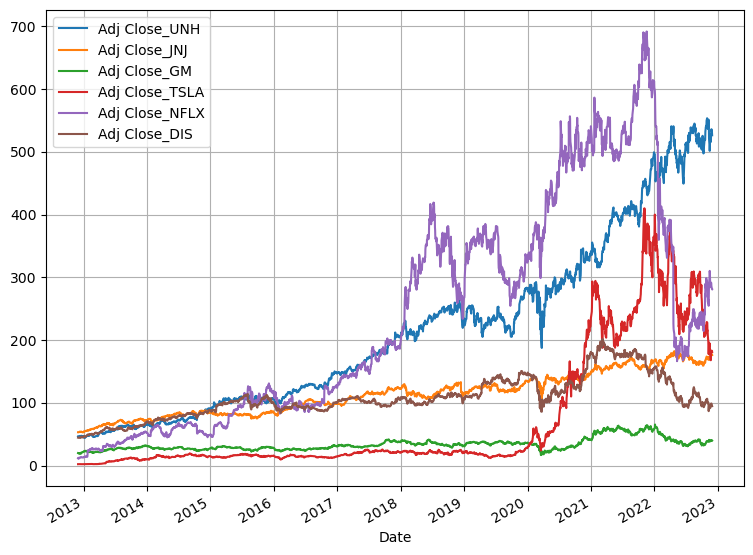

In [6]:
adj_closes = pd.DataFrame() # dataframe che contiene gli adj close dei titoli
for name in stocks_names:
    tmp_df = stocks[name]['Adj Close'].to_frame()
    tmp_df.columns = ['Adj Close_' + name]
    adj_closes = pd.concat([adj_closes, tmp_df], axis=1)
    
    
adj_closes.plot(grid=True, figsize=(9,7), legend=True);

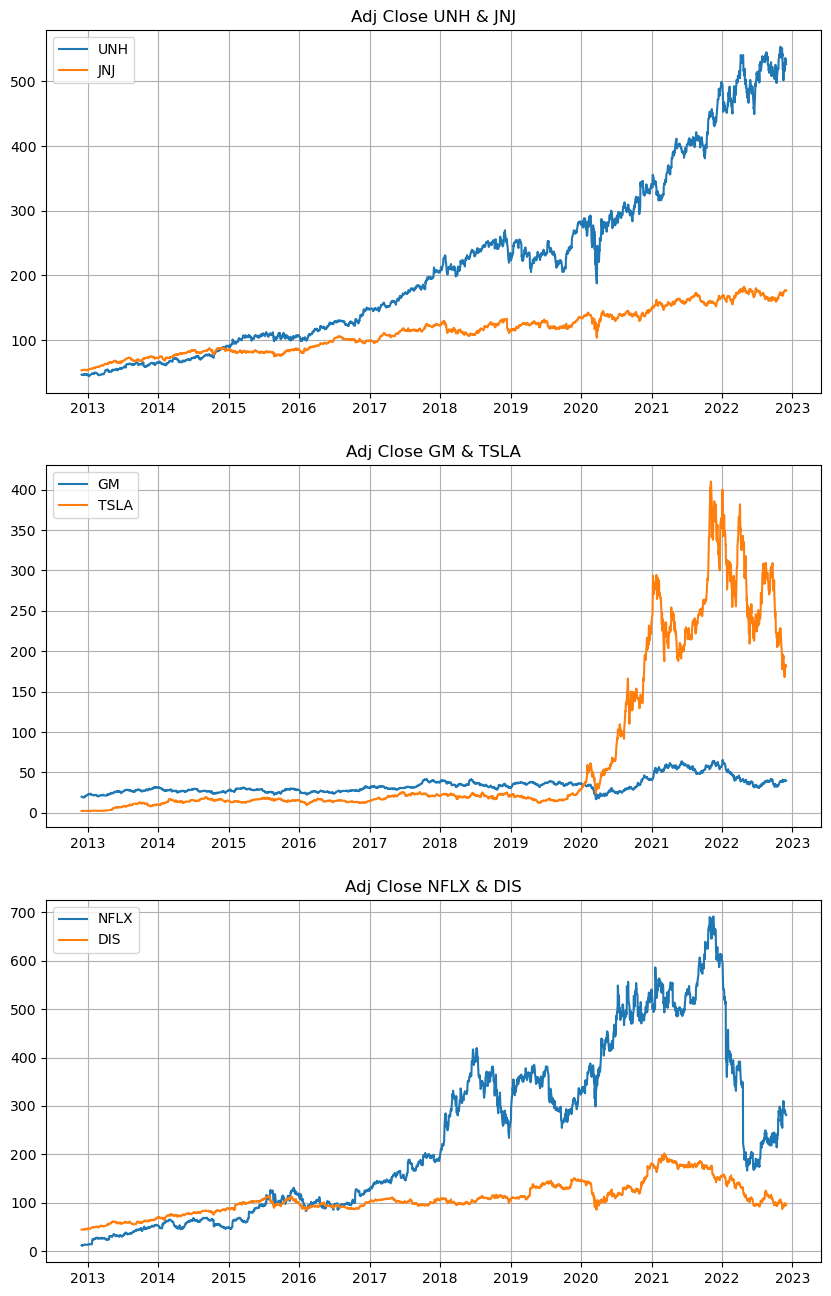

In [7]:
# plotto gli adj close a coppia per settore

plt.figure(figsize=(10,16))
for index in range(0, len(stocks_names)-1, 2): # [0,2,4]
    name_1 = stocks_names[index]
    name_2 = stocks_names[index+1]
    
    plt.subplot(311 + int(index/2)) # 3 righe, 1 colonna, numero figura (parte da 1)
    plt.title('Adj Close ' + name_1 + ' & ' + name_2)
    plt.plot(stocks[name_1]['Adj Close'])
    plt.plot(stocks[name_2]['Adj Close'])
    plt.legend([name_1, name_2], loc='upper left')
    plt.grid()

In [8]:
adj_closes.head()

Adj Close_UNH  Adj Close_JNJ  Adj Close_GM  Adj Close_TSLA  \
Date                                                                     
2012-11-30      46.453590      53.113277     19.912640        2.254667   
2012-12-03      46.026550      53.052334     19.627954        2.308000   
2012-12-04      45.727623      53.212296     19.551014        2.260000   
2012-12-05      45.983856      53.296082     19.235548        2.247333   
2012-12-06      45.821579      53.357021     18.904694        2.260000   

            Adj Close_NFLX  Adj Close_DIS  
Date                                       
2012-11-30       11.672857      44.462769  
2012-12-03       10.857143      44.131493  
2012-12-04       12.378571      44.140438  
2012-12-05       11.910000      44.400097  
2012-12-06       12.310000      44.600094

In [9]:
adj_closes.tail()

Adj Close_UNH  Adj Close_JNJ  Adj Close_GM  Adj Close_TSLA  \
Date                                                                     
2022-11-22     521.482483     176.820007     39.881310      169.910004   
2022-11-23     528.082153     177.009995     40.021000      183.199997   
2022-11-25     535.967834     177.240005     40.370220      182.860001   
2022-11-28     530.634277     177.330002     39.292618      182.919998   
2022-11-29     526.377380     176.089996     39.661797      180.830002   

            Adj Close_NFLX  Adj Close_DIS  
Date                                       
2022-11-22      286.690002      96.209999  
2022-11-23      291.500000      98.879997  
2022-11-25      285.540009      98.870003  
2022-11-28      281.170013      95.690002  
2022-11-29      280.959991      94.690002

In [10]:
adj_closes.describe()

Adj Close_UNH  Adj Close_JNJ  Adj Close_GM  Adj Close_TSLA  \
count    2517.000000    2517.000000   2517.000000     2517.000000   
mean      214.772239     113.268050     33.610196       71.796687   
std       137.922805      33.036382      9.505687      101.868080   
min        44.074879      52.922859     16.724537        2.194000   
25%       102.878525      82.829956     26.974800       14.433333   
50%       198.205872     114.352219     31.132095       18.648001   
75%       285.904663     137.433487     37.119846       59.873333   
max       553.443970     182.411407     65.444702      409.970001   

       Adj Close_NFLX  Adj Close_DIS  
count     2517.000000    2517.000000  
mean       236.612867     107.899626  
std        175.370038      32.942904  
min         10.857143      44.131493  
25%         87.879997      90.145126  
50%        187.759995     102.866318  
75%        361.809998     124.980003  
max        691.690002     201.910004

## 2. Statistiche descrittive

In [11]:
# RENDIMENTO CUMULATO

cum_rtn = pd.DataFrame()

for index in range(0, len(stocks_names)):
    cum_rtn['cum_rtn_' + stocks_names[index]] = [adj_closes.iloc[-1, index] / adj_closes.iloc[0, index] - 1]
    
cum_rtn

cum_rtn_UNH  cum_rtn_JNJ  cum_rtn_GM  cum_rtn_TSLA  cum_rtn_NFLX  \
0    10.331253     2.315367     0.99179      79.20253     23.069513   

   cum_rtn_DIS  
0     1.129647

In [12]:
# RENDIMENTO COMPOSTO ANNUO

comp_rtn = pd.DataFrame()

for index in range(0, len(stocks_names)):
    # (radice decima di (valore finale/valore iniziale)) - 1
    comp_rtn['y_comp_rtn_' + stocks_names[index]] = [((adj_closes.iloc[-1, index] / adj_closes.iloc[0, index]) ** (1/10)) - 1]
    
comp_rtn

y_comp_rtn_UNH  y_comp_rtn_JNJ  y_comp_rtn_GM  y_comp_rtn_TSLA  \
0        0.274758        0.127335       0.071333         0.550311   

   y_comp_rtn_NFLX  y_comp_rtn_DIS  
0         0.374506        0.078526

In [13]:
# RENDIMENTO SEMPLICE

simple_ret = adj_closes / adj_closes.shift(1) - 1 # oppure .pct_change(1)

simple_ret.dropna(inplace=True)

simple_ret.columns = ['[D] Simple ret. ' + name for name in stocks_names]

simple_ret.head()

[D] Simple ret. UNH  [D] Simple ret. JNJ  [D] Simple ret. GM  \
Date                                                                       
2012-12-03            -0.009193            -0.001147           -0.014297   
2012-12-04            -0.006495             0.003015           -0.003920   
2012-12-05             0.005603             0.001575           -0.016136   
2012-12-06            -0.003529             0.001143           -0.017200   
2012-12-07             0.008103             0.005710            0.025234   

            [D] Simple ret. TSLA  [D] Simple ret. NFLX  [D] Simple ret. DIS  
Date                                                                         
2012-12-03              0.023655             -0.069881            -0.007451  
2012-12-04             -0.020797              0.140131             0.000203  
2012-12-05             -0.005605             -0.037853             0.005883  
2012-12-06              0.005636              0.033585             0.004504  
2012-12-07              0.007965             -0.002205             0.003669

In [14]:
# RENDIMENTO LOGARITMICO

daily_log_rtn = np.log(1 + simple_ret) 

daily_log_rtn.columns = ['[D] Log ret. ' + name for name in stocks_names]

daily_log_rtn.head()

[D] Log ret. UNH  [D] Log ret. JNJ  [D] Log ret. GM  \
Date                                                              
2012-12-03         -0.009235         -0.001148        -0.014400   
2012-12-04         -0.006516          0.003011        -0.003928   
2012-12-05          0.005588          0.001573        -0.016267   
2012-12-06         -0.003535          0.001143        -0.017350   
2012-12-07          0.008070          0.005694         0.024921   

            [D] Log ret. TSLA  [D] Log ret. NFLX  [D] Log ret. DIS  
Date                                                                
2012-12-03           0.023379          -0.072443         -0.007479  
2012-12-04          -0.021017           0.131144          0.000203  
2012-12-05          -0.005621          -0.038588          0.005865  
2012-12-06           0.005621           0.033034          0.004494  
2012-12-07           0.007933          -0.002207          0.003662

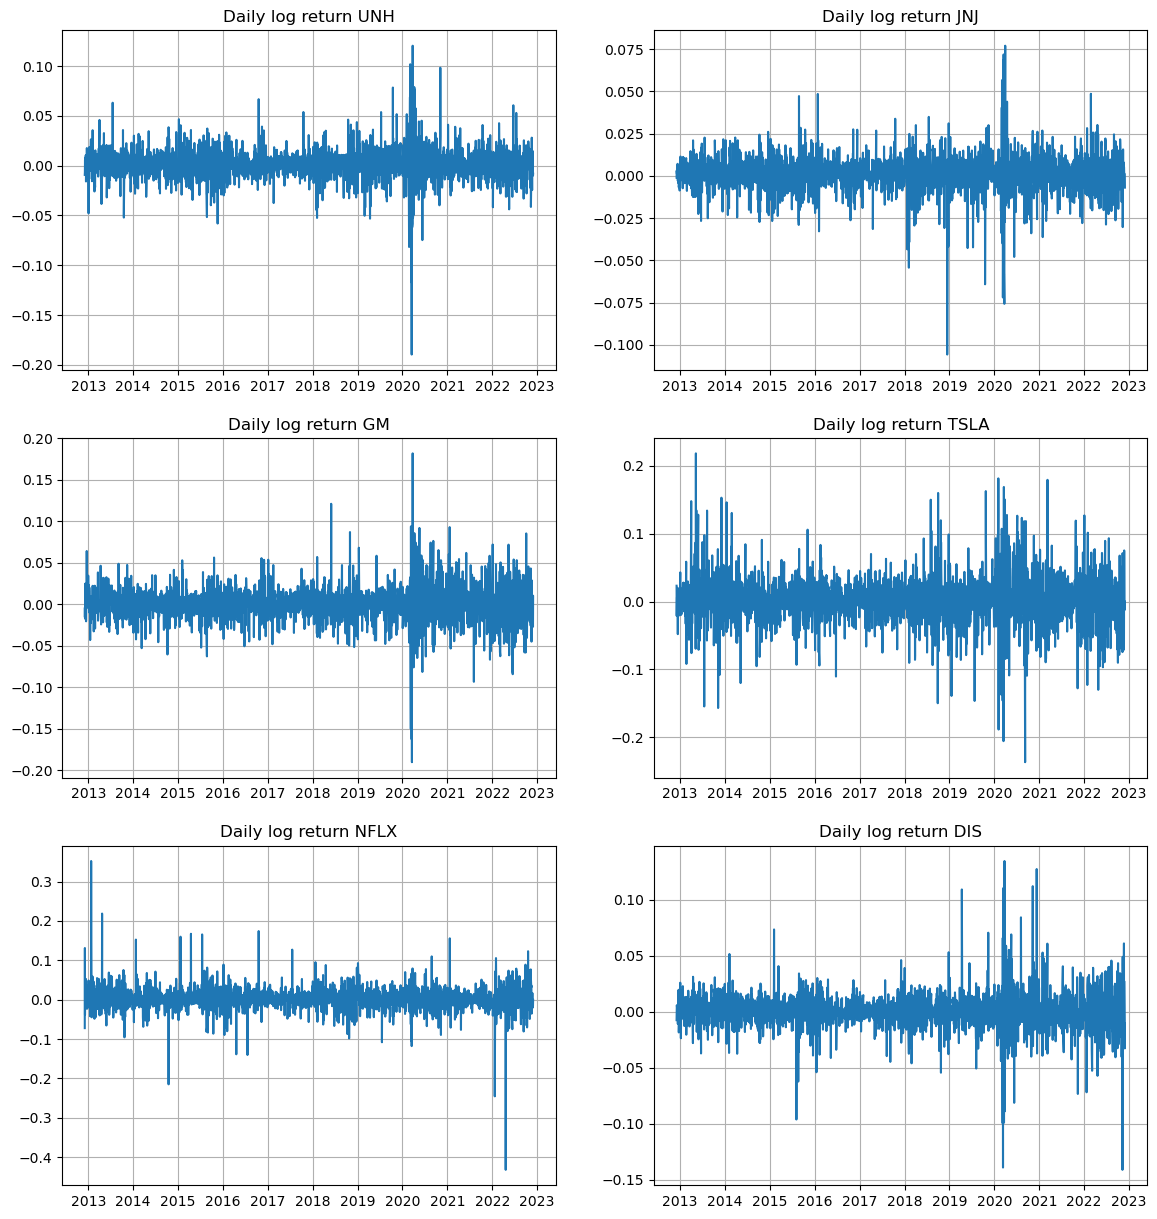

In [15]:
plt.figure(figsize=(14,15))
for index in range(0, len(stocks_names)):
    name = stocks_names[index]
    plt.subplot(321 + index) # 3 righe, 2 colonne, numero figura (parte da 1)
    plt.title('Daily log return ' + name)
    plt.plot(daily_log_rtn['[D] Log ret. ' + name])
    plt.grid()

In [16]:
daily_log_rtn.describe()

[D] Log ret. UNH  [D] Log ret. JNJ  [D] Log ret. GM  [D] Log ret. TSLA  \
count       2516.000000       2516.000000      2516.000000        2516.000000   
mean           0.000965          0.000476         0.000274           0.001743   
std            0.015964          0.011146         0.021475           0.035570   
min           -0.189671         -0.105781        -0.190227          -0.236518   
25%           -0.006775         -0.004502        -0.009934          -0.014888   
50%            0.001054          0.000530         0.000599           0.001427   
75%            0.008492          0.006011         0.010333           0.018793   
max            0.120437          0.076940         0.181848           0.218292   

       [D] Log ret. NFLX  [D] Log ret. DIS  
count        2516.000000       2516.000000  
mean            0.001264          0.000300  
std             0.030039          0.016569  
min            -0.432578         -0.141139  
25%            -0.012155         -0.006736  
50%             0.000434          0.000422  
75%             0.014880          0.007700  
max             0.352230          0.134639

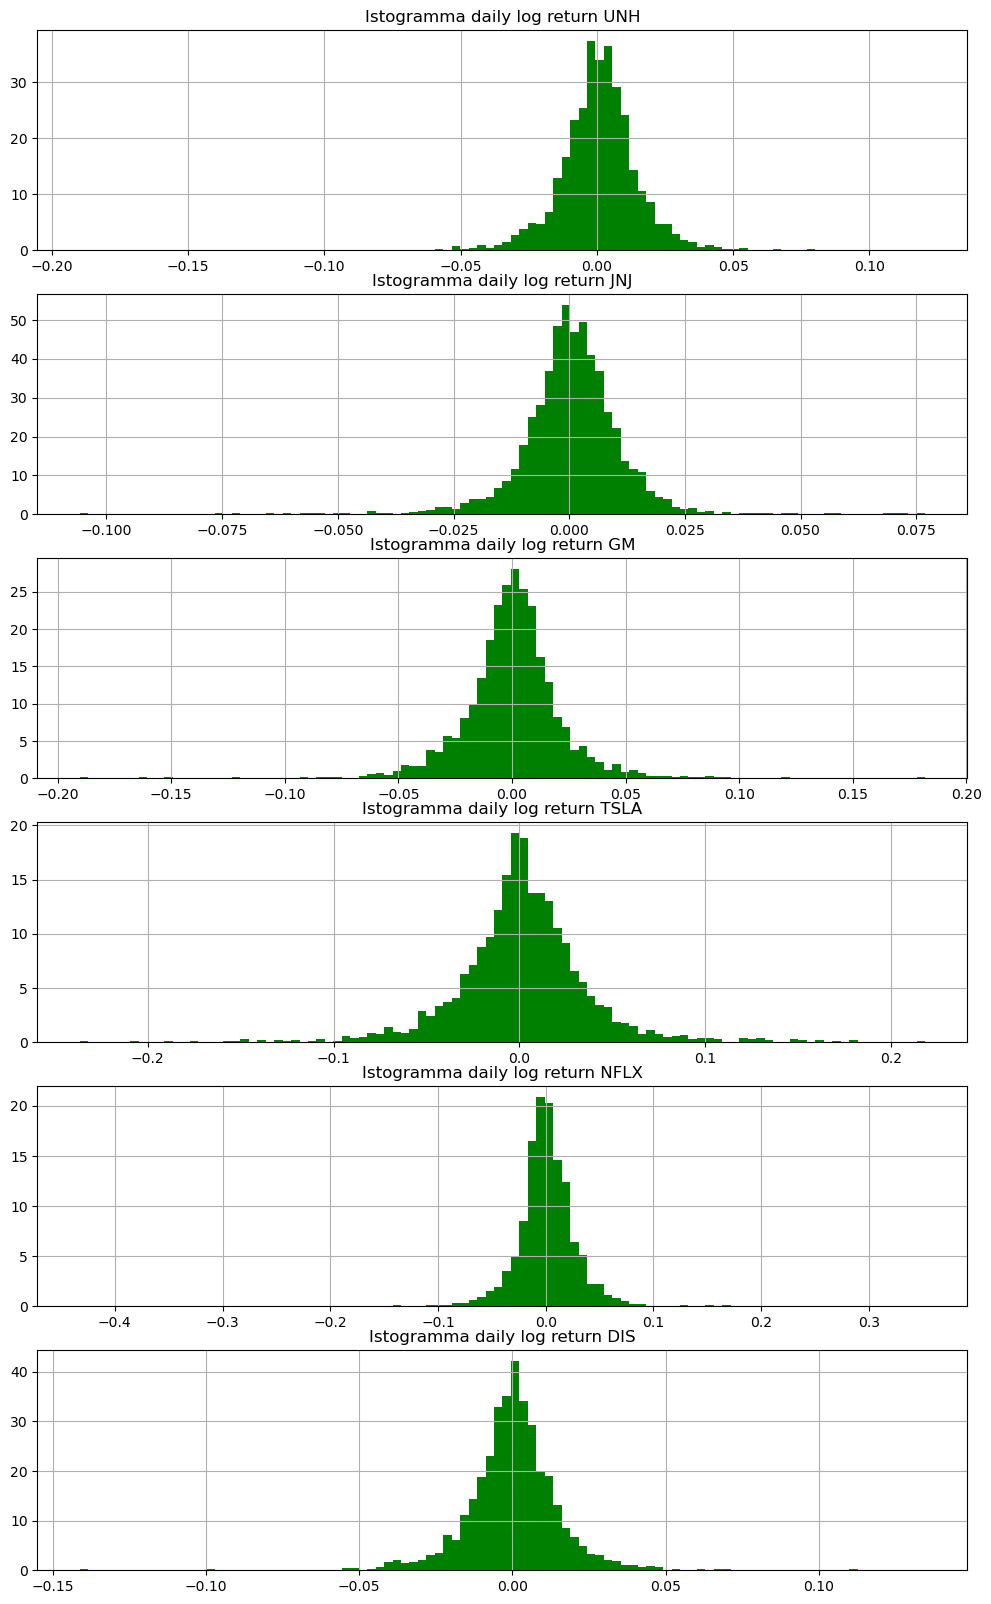

In [17]:
# ISTOGRAMMI

plt.figure(figsize=(12,20))
for index in range(0, len(stocks_names)):
    name = stocks_names[index]
    
    #info = daily_log_rtn['[D] Log ret. ' + name].describe()
    
    #plt.axvline(x=info[3], linewidth=2, color='r') # min
    #plt.axvline(x=info[4], linewidth=2, color='b') # primo quartile
    #plt.axvline(x=info[5], linewidth=2, color='g') # mediana
    #plt.axvline(x=info[6], linewidth=2, color='b') # terzo quartile
    #plt.axvline(x=info[7], linewidth=2, color='r') # max
    
    plt.subplot(611 + index) # 6 righe, 1 colonna, numero figura (parte da 1)
    
    
    
    plt.hist(daily_log_rtn['[D] Log ret. ' + name], density = True, bins = 100, color='green')
    #daily_log_rtn['[D] Log ret. ' + name].plot.density(color='red')
    plt.title('Istogramma daily log return ' + name)
    plt.grid()

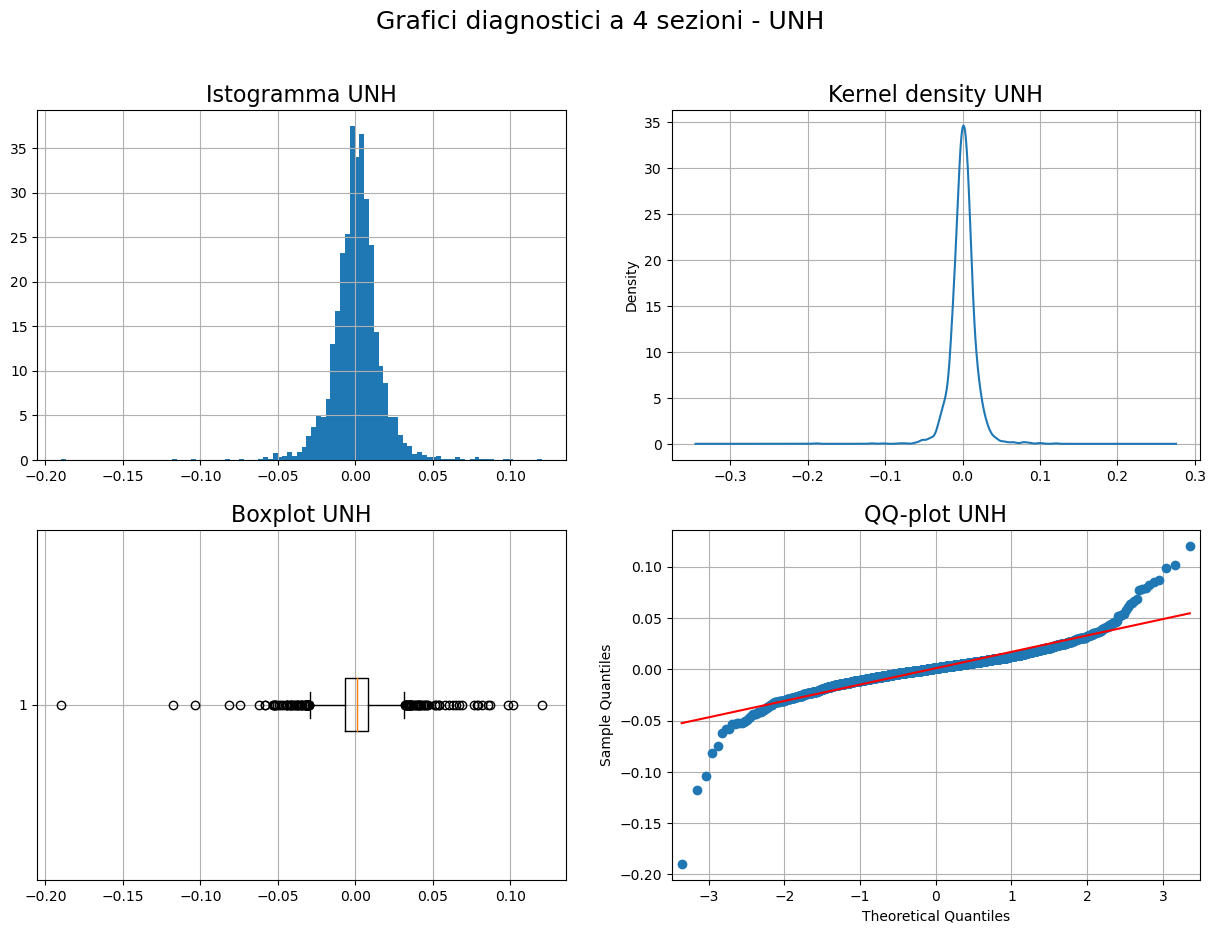

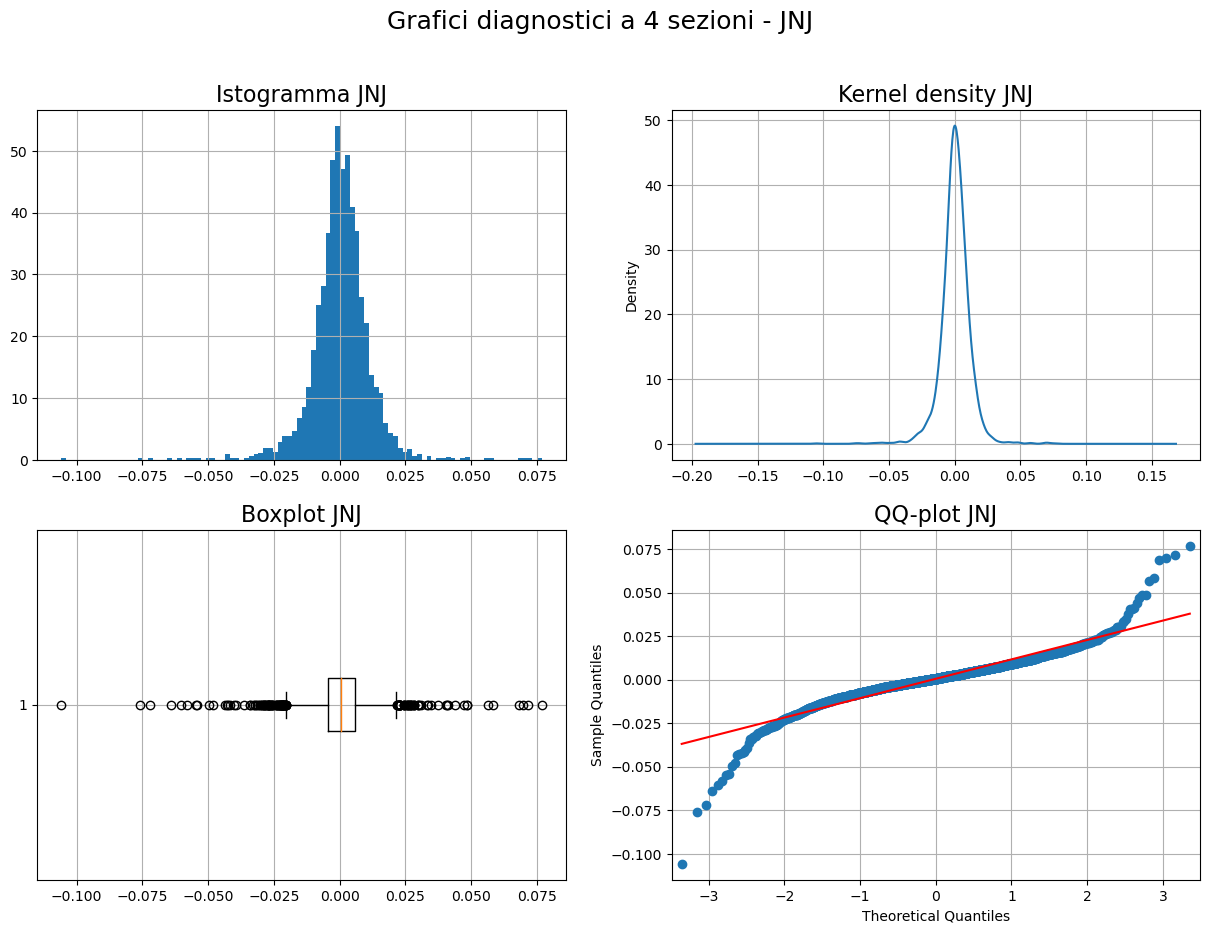

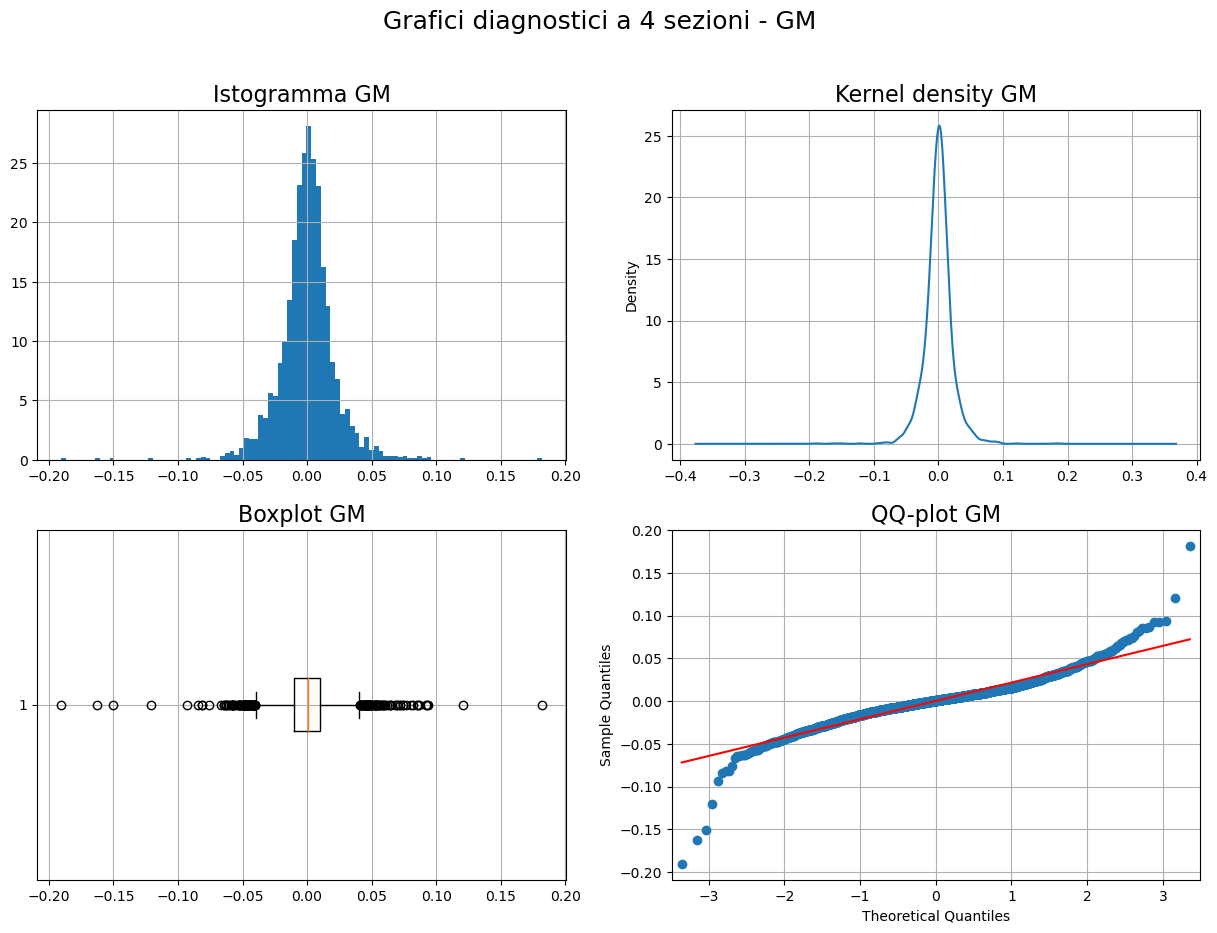

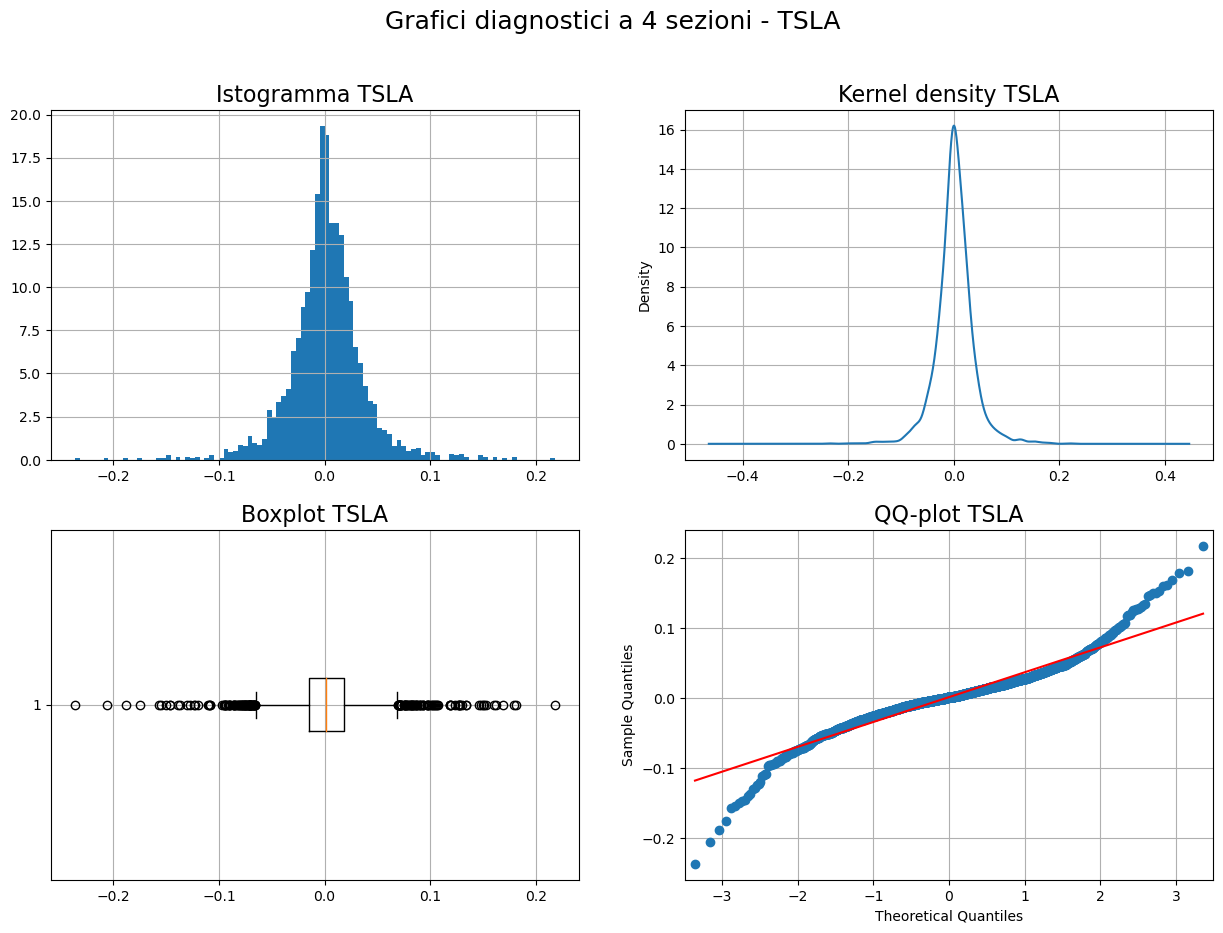

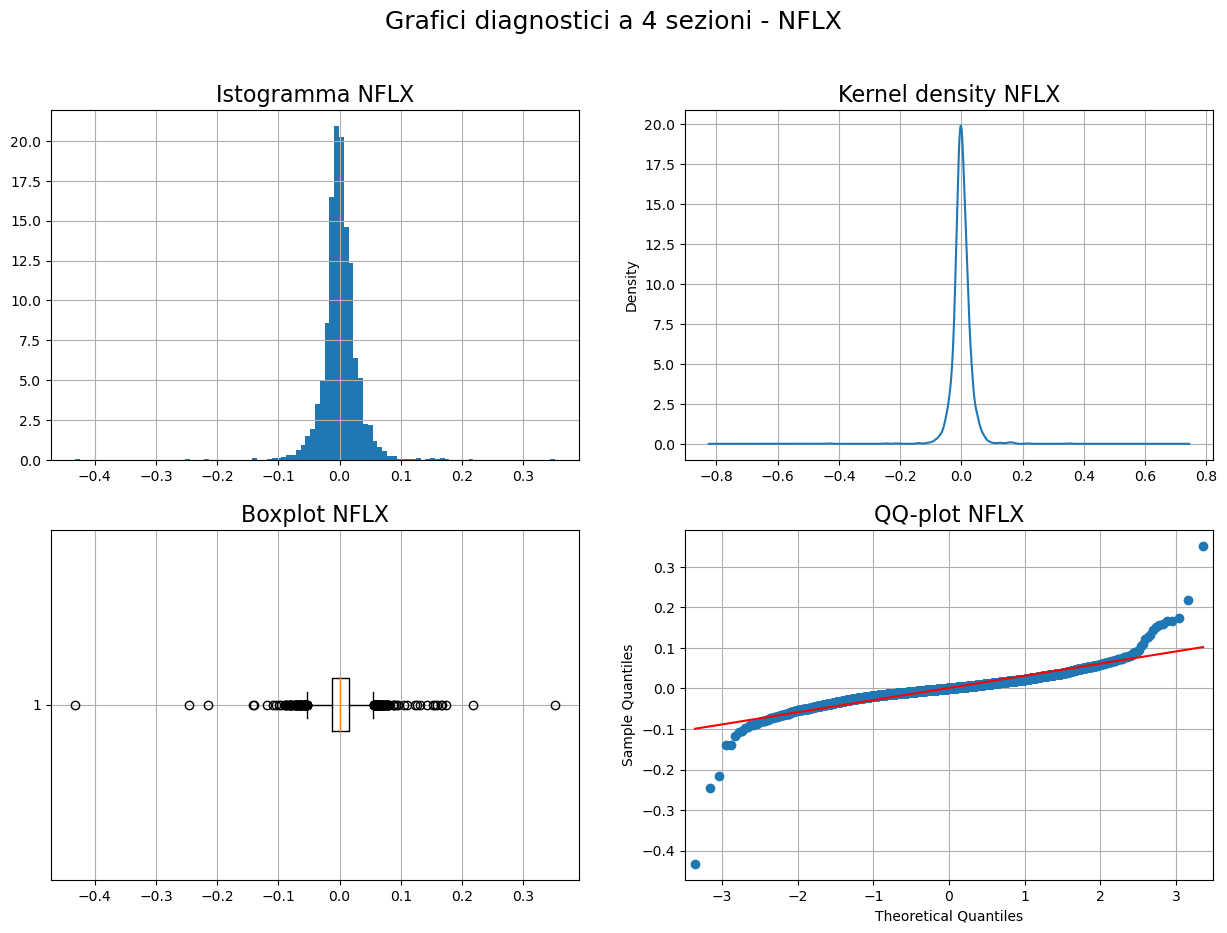

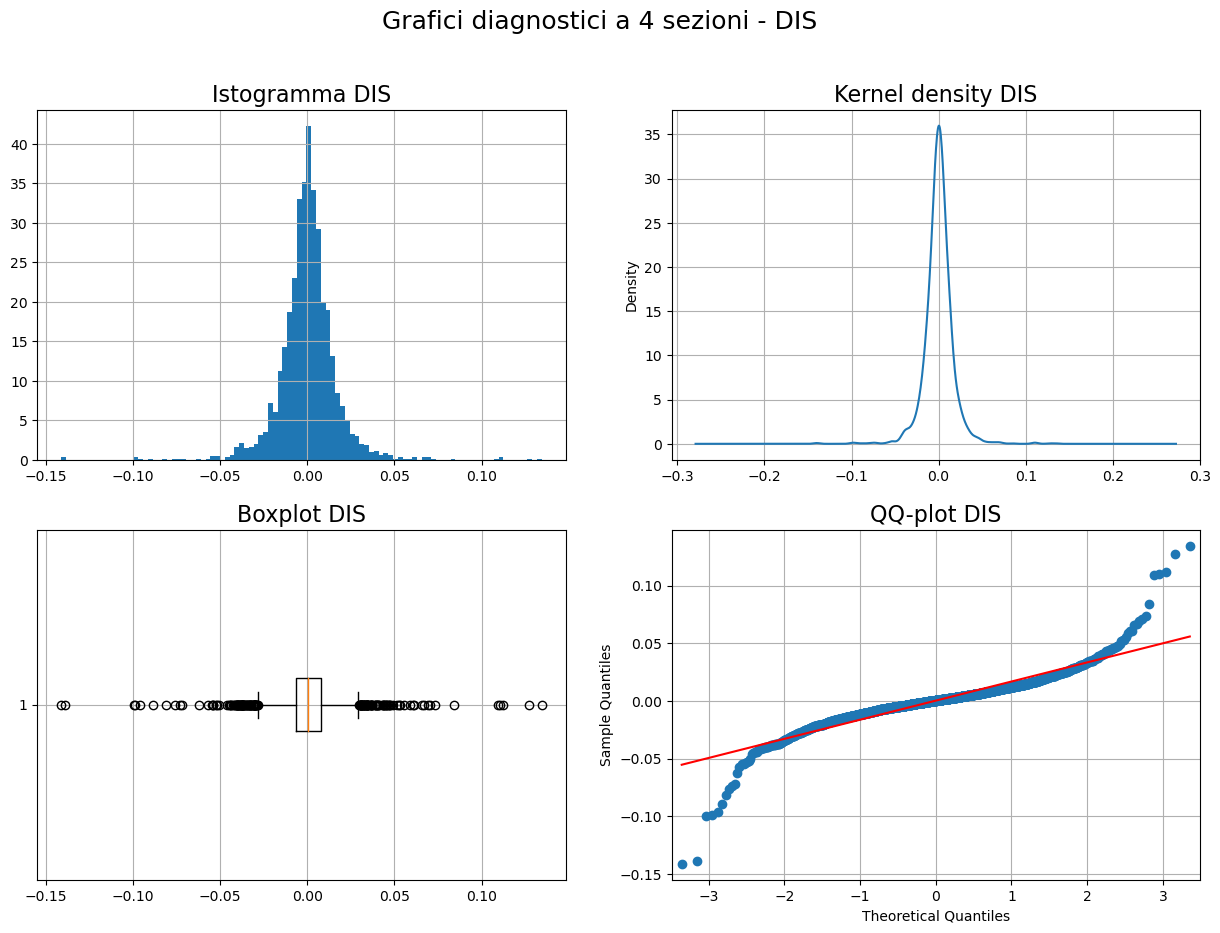

In [18]:
# GRAFICI DIAGNOSTICI A 4 SEZIONI

for name in stocks_names:
    
    fig = plt.figure(figsize=(15,10))
    
    fig.suptitle('Grafici diagnostici a 4 sezioni - ' + name, fontsize=18)
    
    data = daily_log_rtn['[D] Log ret. ' + name]
    
    # istogramma
    
    plt.subplot(221).set_title("Istogramma " + name, fontsize=16)
    
    plt.hist(data, density = True, bins = 100)
    
    plt.grid()
    
    # kernel density
    
    plt.subplot(222).set_title("Kernel density " + name, fontsize=16)
    
    data.plot.kde()
    
    plt.grid()
    
    # boxplot
    
    plt.subplot(223).set_title("Boxplot " + name, fontsize=16)
    
    plt.boxplot(data, vert = False)
    
    plt.grid()
    
    # qq-plot
    
    ax = plt.subplot(224)
    
    ax.set_title("QQ-plot " + name, fontsize=16)
    
    sm.qqplot(data, line='s', ax=ax)
    
    plt.grid()

In [19]:
# STATISTICHE DESCRITTIVE UNIVARIATE
for name in stocks_names:
    data = daily_log_rtn['[D] Log ret. ' + name]
    info = data.describe(include='all')
    mean = str(round(info[1], 6))
    var = str(round((info[2] ** 2), 6))
    std = str(round(info[2], 6))
    skewness = str(round(data.skew(), 6))
    kurtosis = str(round(data.kurtosis(), 6))
    
    print("\n*** Statistiche descrittive univariate " + name + " ***")
    print('{:>12} {:>12}'.format("Media:", mean))
    print('{:>12} {:>12}'.format("Varianza:", var))
    print('{:>12} {:>12}'.format("Std. dev.:", std))
    print('{:>12} {:>12}'.format("Asimmetria:", skewness))
    print('{:>12} {:>12}'.format("Curtosi:", kurtosis))


*** Statistiche descrittive univariate UNH ***
      Media:     0.000965
   Varianza:     0.000255
  Std. dev.:     0.015964
 Asimmetria:    -0.397418
    Curtosi:    14.773449

*** Statistiche descrittive univariate JNJ ***
      Media:     0.000476
   Varianza:     0.000124
  Std. dev.:     0.011146
 Asimmetria:    -0.474644
    Curtosi:    10.249178

*** Statistiche descrittive univariate GM ***
      Media:     0.000274
   Varianza:     0.000461
  Std. dev.:     0.021475
 Asimmetria:    -0.196396
    Curtosi:     8.716011

*** Statistiche descrittive univariate TSLA ***
      Media:     0.001743
   Varianza:     0.001265
  Std. dev.:      0.03557
 Asimmetria:     0.020611
    Curtosi:     5.181715

*** Statistiche descrittive univariate NFLX ***
      Media:     0.001264
   Varianza:     0.000902
  Std. dev.:     0.030039
 Asimmetria:     -0.41181
    Curtosi:     31.01424

*** Statistiche descrittive univariate DIS ***
      Media:       0.0003
   Varianza:     0.000275
  Std. de

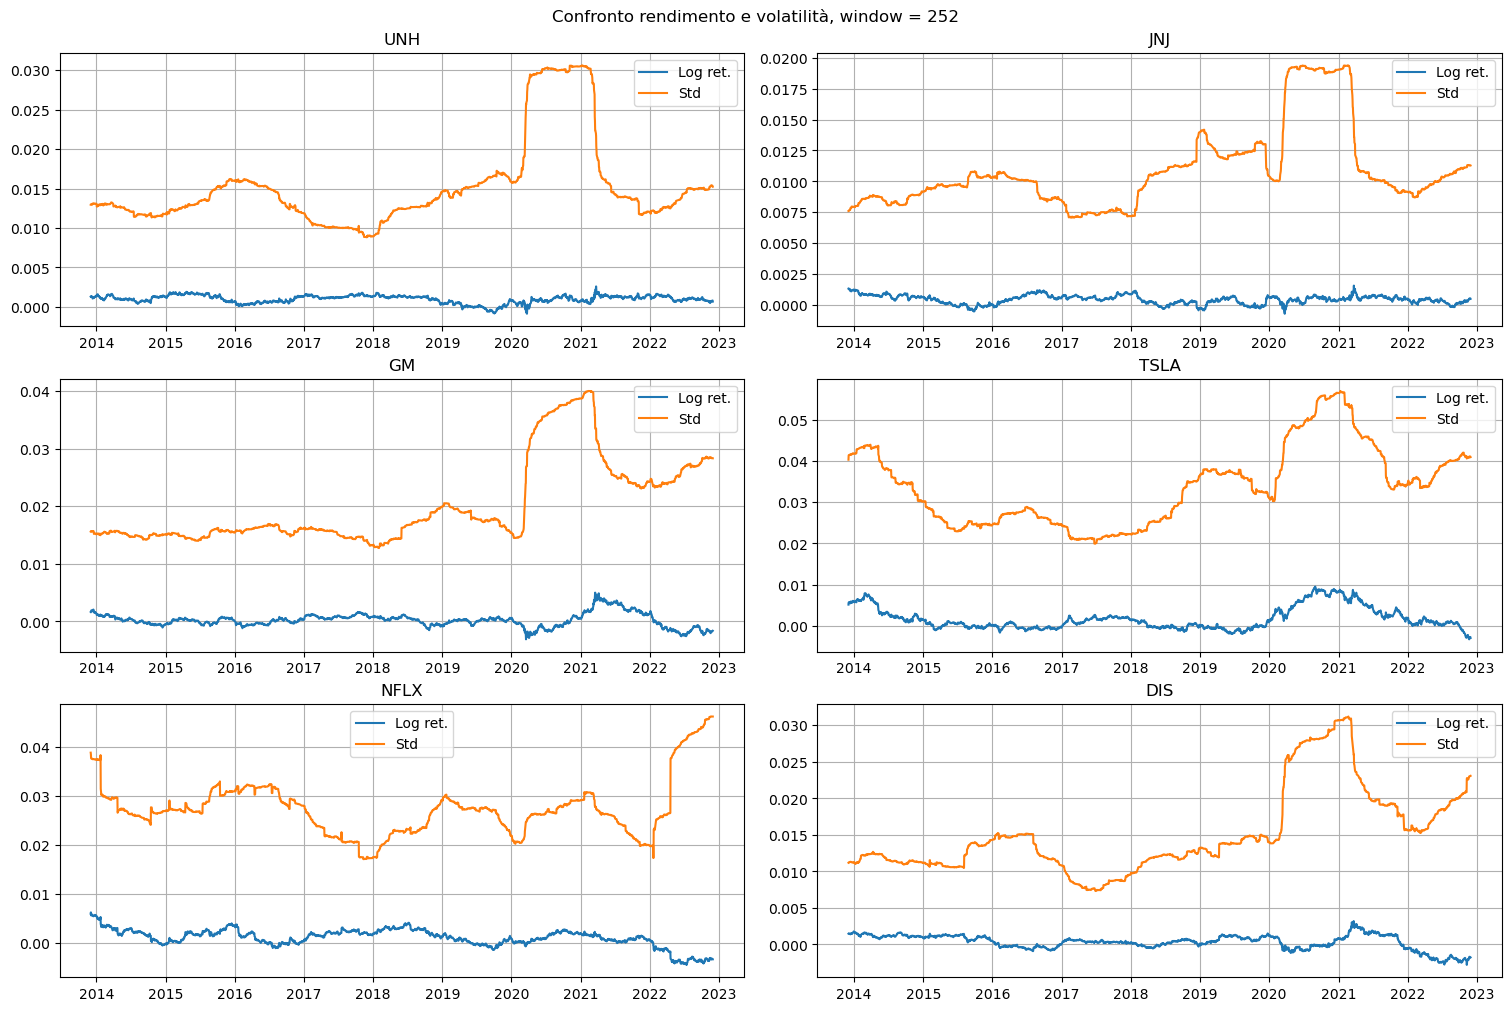

In [20]:
# CONFRONTO NEL TEMPO RENDIMENTO E VOLATILITA'

fig = plt.figure(figsize=(15,10), constrained_layout = True)
fig.suptitle('Confronto rendimento e volatilità, window = 252')
for index in range(0, len(stocks_names)):
    name = stocks_names[index]
    plt.subplot(321 + index) # 3 righe, 2 colonne, numero figura (parte da 1)
    plt.title(name)
    plt.plot(daily_log_rtn['[D] Log ret. ' + name].rolling(252).mean())
    plt.plot(daily_log_rtn['[D] Log ret. ' + name].rolling(252).std())
    plt.legend(['Log ret.', 'Std'])
    plt.grid()

UNH       JNJ        GM      TSLA      NFLX       DIS
UNH   0.000255  0.000088  0.000127  0.000124  0.000109  0.000099
JNJ   0.000088  0.000124  0.000066  0.000059  0.000059  0.000065
GM    0.000127  0.000066  0.000461  0.000237  0.000142  0.000180
TSLA  0.000124  0.000059  0.000237  0.001265  0.000344  0.000173
NFLX  0.000109  0.000059  0.000142  0.000344  0.000902  0.000148
DIS   0.000099  0.000065  0.000180  0.000173  0.000148  0.000275

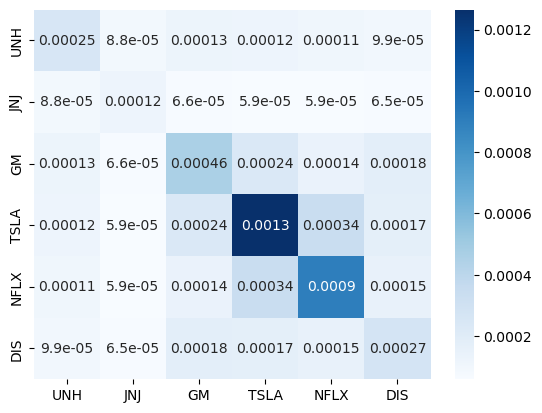

In [21]:
# MATRICE DI VARIANZE/COVARIANZE

cov_matrix = daily_log_rtn.copy().cov()
cov_matrix.index = stocks_names
cov_matrix.columns = stocks_names

fig, ax = plt.subplots(1,1)
img = sns.heatmap(cov_matrix, annot = True, cmap = 'Blues')

cov_matrix

UNH       JNJ        GM      TSLA      NFLX       DIS
UNH   1.000000  0.493877  0.371687  0.218724  0.227104  0.375993
JNJ   0.493877  1.000000  0.274861  0.148973  0.175316  0.352397
GM    0.371687  0.274861  1.000000  0.310586  0.220750  0.507188
TSLA  0.218724  0.148973  0.310586  1.000000  0.321532  0.293799
NFLX  0.227104  0.175316  0.220750  0.321532  1.000000  0.298163
DIS   0.375993  0.352397  0.507188  0.293799  0.298163  1.000000

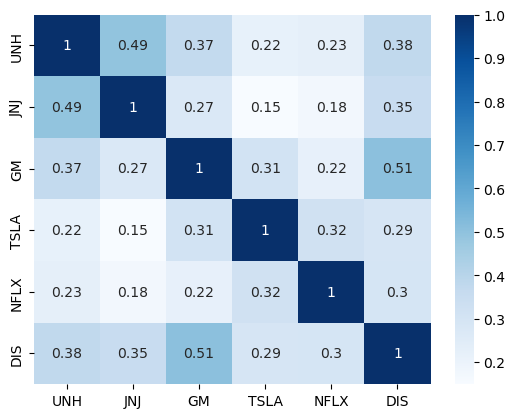

In [22]:
# MATRICE DI CORRELAZIONE

corr_matrix = daily_log_rtn.copy().corr()
corr_matrix.index = stocks_names
corr_matrix.columns = stocks_names

fig, ax = plt.subplots(1,1)
img = sns.heatmap(corr_matrix, annot = True, cmap = 'Blues')

corr_matrix

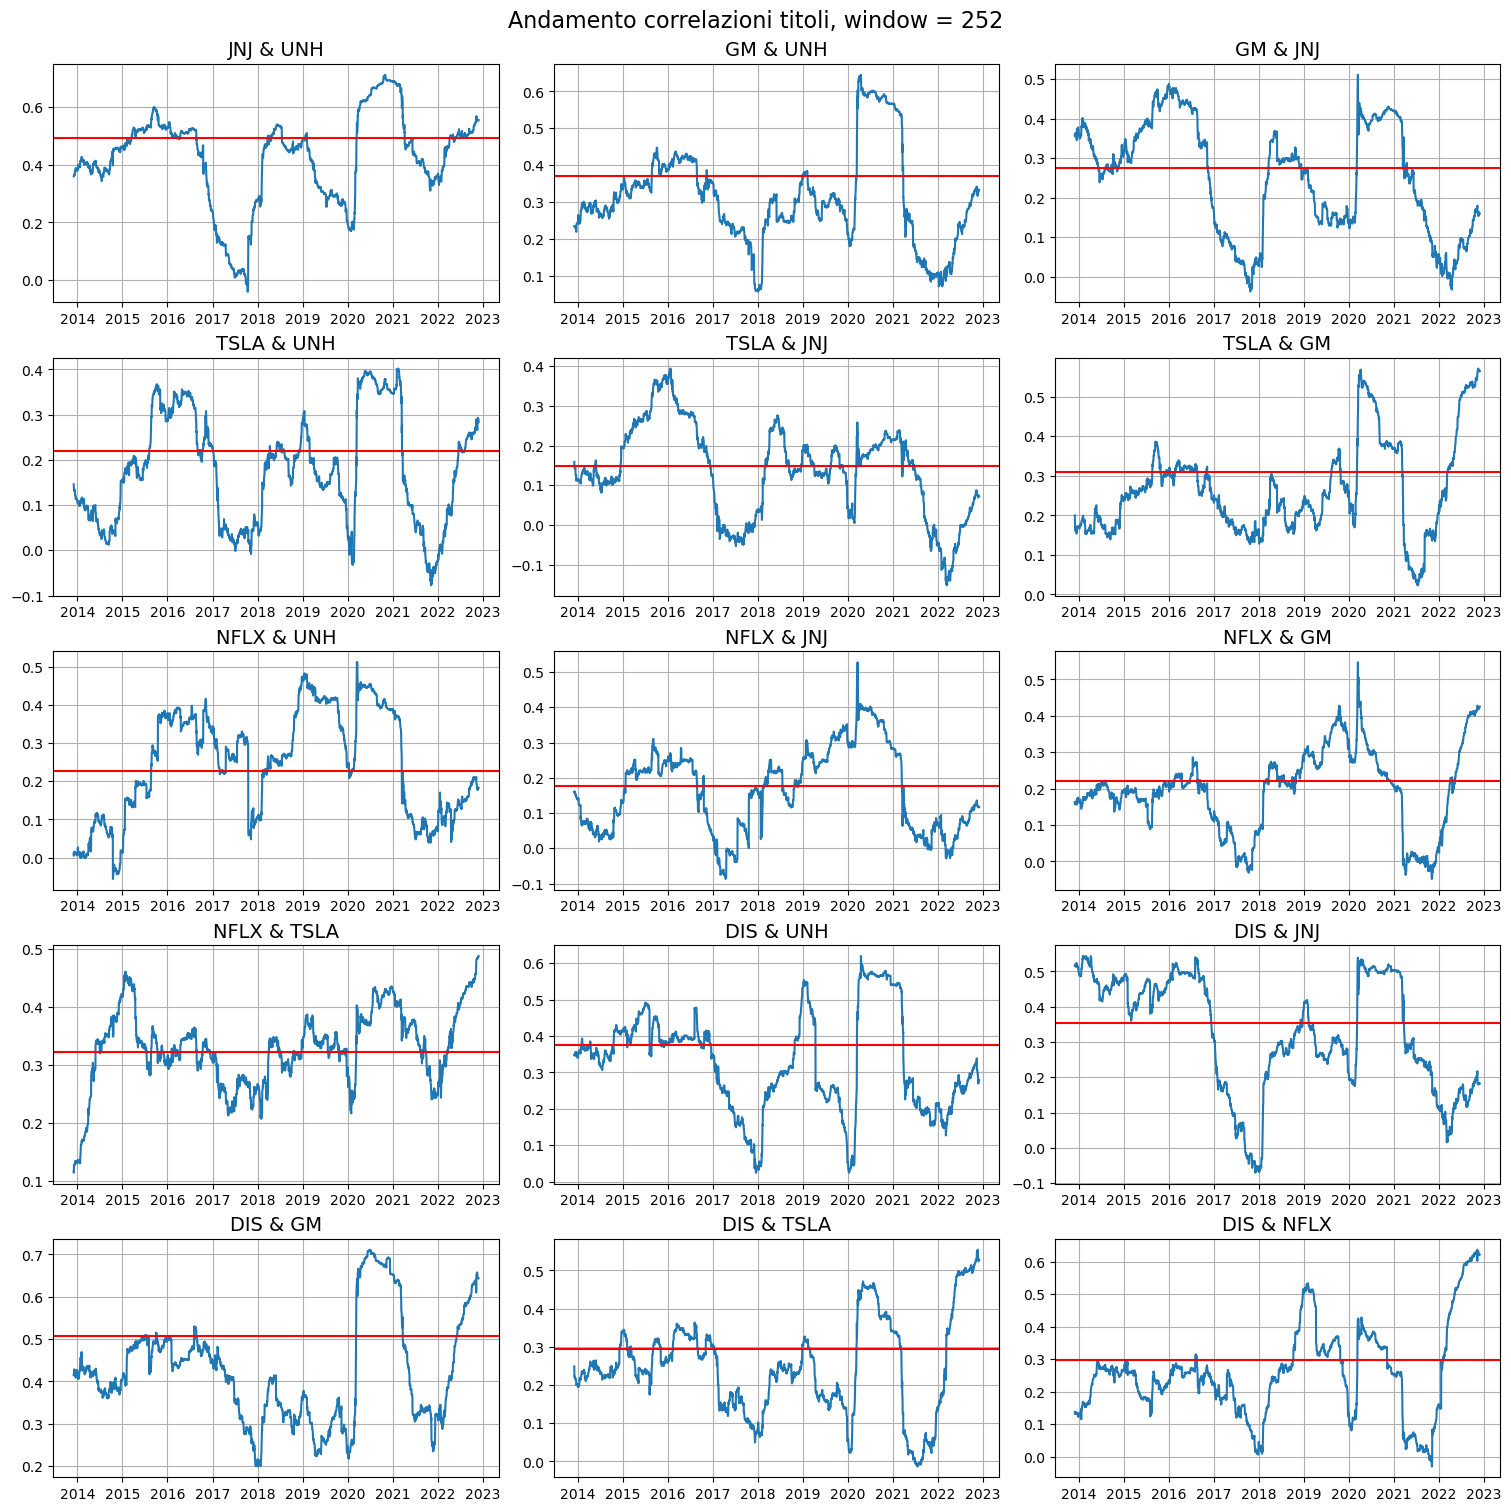

In [23]:
# ANDAMENTO CORRELAZIONI FRA I TITOLI

(row, col) = (0, 0)

fig, axs = plt.subplots(5, 3, figsize=(15, 15), constrained_layout = True) # 5 x 3 perche' ho 15 coppie
    
fig.suptitle('Andamento correlazioni titoli, window = 252', fontsize=16)
# 252 = trading days in a year

# prendo il triangolo inferiore della matrice per avere coppie distinte
for i in range(0, 6):
    for j in range(0, i):
        stock_1 = stocks_names[i]
        stock_2 = stocks_names[j]
        
        ax = axs[row, col]
        
        col += 1
        if col == 3:
            col = 0
            row += 1
        
        ax.set_title(stock_1 + ' & ' + stock_2, fontsize=14)
        
        ax.plot(daily_log_rtn['[D] Log ret. ' + stock_1].rolling(window = 252).corr(daily_log_rtn['[D] Log ret. ' + stock_2]))
        # correlazione su una finestra di 252 days
        
        ax.axhline(corr_matrix.iloc[i, j], c = 'r') # correlazione media
        
        ax.grid()

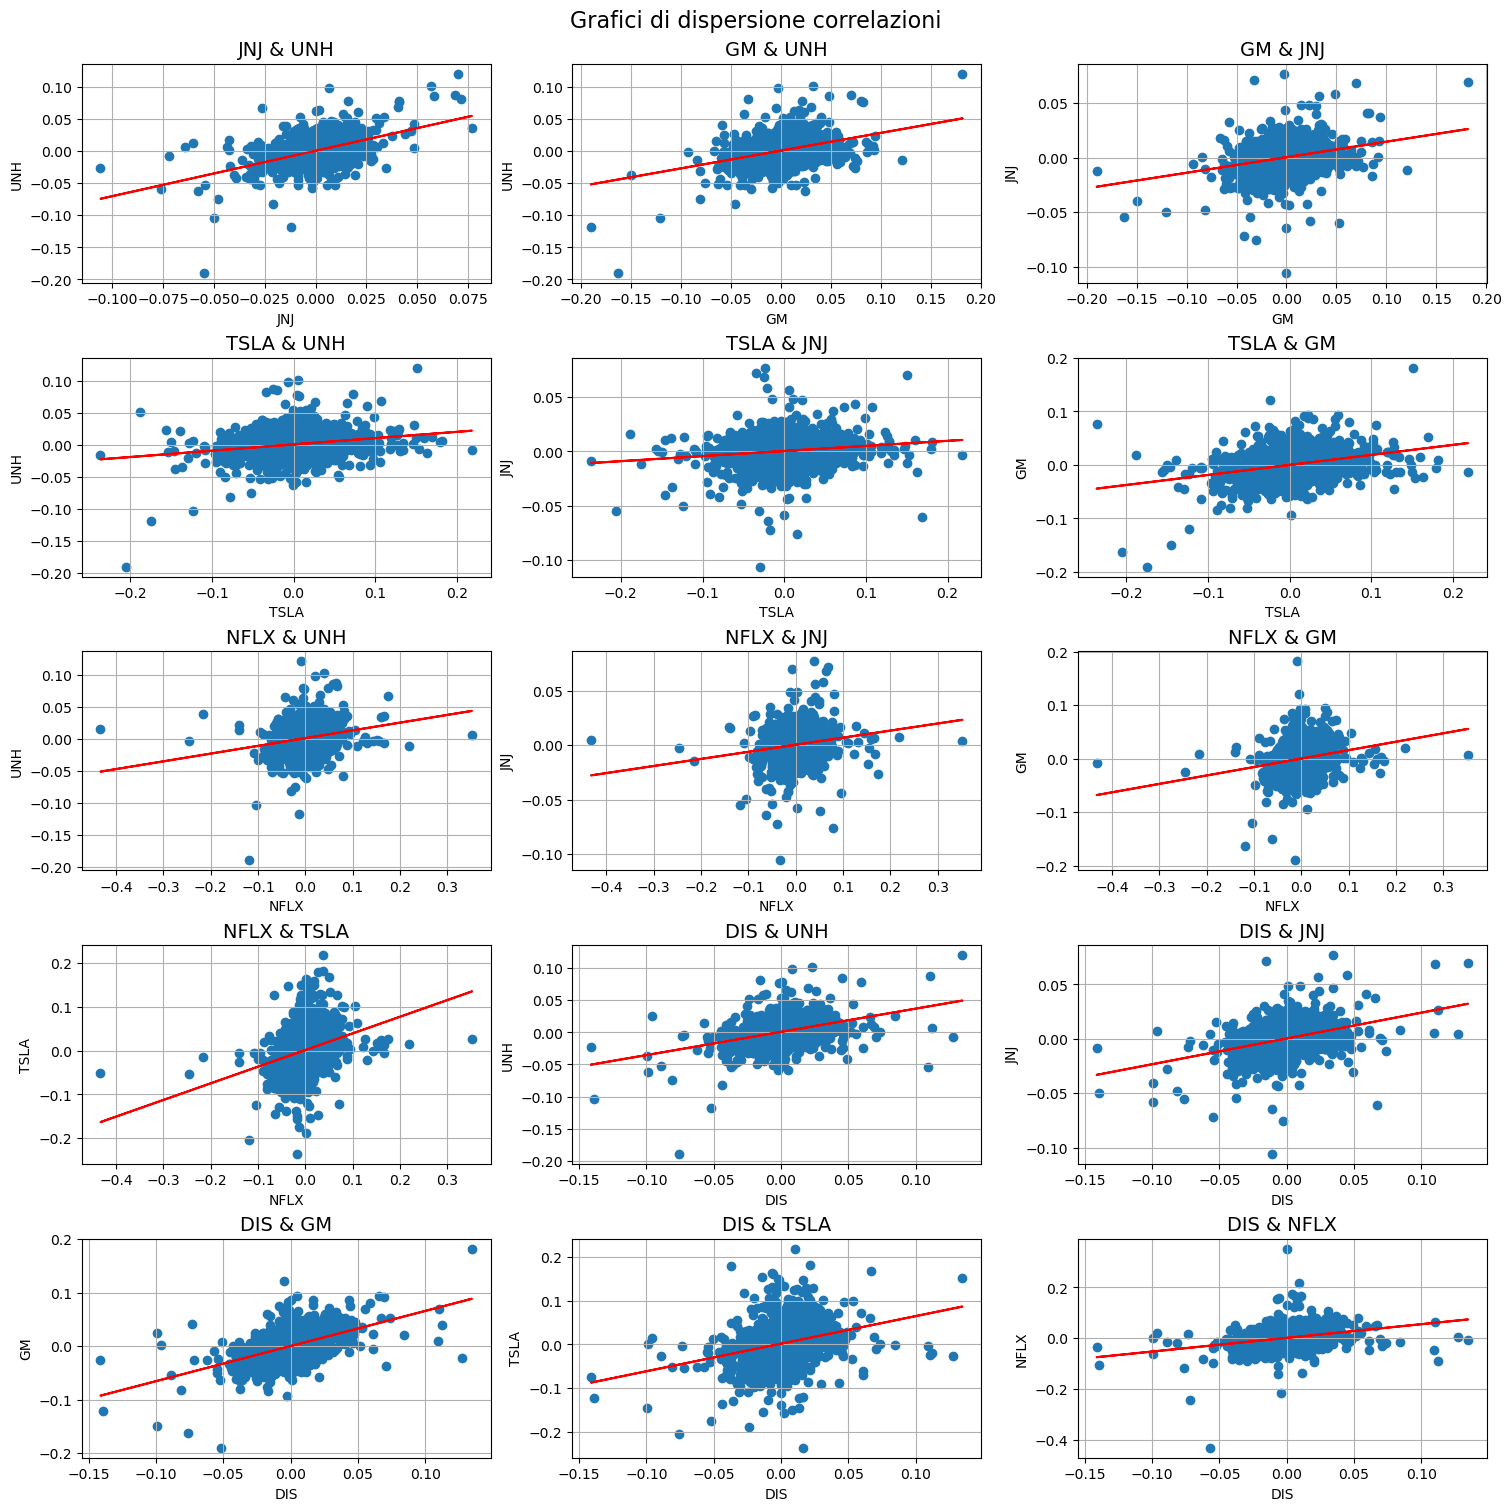

In [24]:
# GRAFICI DI DISPERSIONE CORRELAZIONI

(row, col) = (0, 0)

fig, axs = plt.subplots(5, 3, figsize=(15, 15), constrained_layout = True)
    
fig.suptitle('Grafici di dispersione correlazioni', fontsize=16)

# prendo il triangolo inferiore della matrice per avere coppie distinte
for i in range(0, 6):
    for j in range(0, i):
        stock_1 = stocks_names[i]
        stock_2 = stocks_names[j]
        
        ax = axs[row, col]
        
        col += 1
        if col == 3:
            col = 0
            row += 1
            
        x = daily_log_rtn['[D] Log ret. ' + stock_1]
        y = daily_log_rtn['[D] Log ret. ' + stock_2]
            
        ax.scatter(x, y)
            
        (m, q) = np.polyfit(x, y, deg = 1)
        # coefficienti retta di regressione
        
        ax.plot(x, m*x+q, c = 'red')
        
        ax.set_xlabel(stock_1)
        ax.set_ylabel(stock_2)
        
        ax.set_title(stock_1 + ' & ' + stock_2, fontsize=14)
        
        ax.grid()

## 3. Analisi di previsione

In [25]:
# adj_close mensile, lo utilizzo più avanti varie volte
adj_closes_m = adj_closes.resample('M').last()
adj_closes_m.head()

Adj Close_UNH  Adj Close_JNJ  Adj Close_GM  Adj Close_TSLA  \
Date                                                                     
2012-11-30      46.453590      53.113277     19.912640        2.254667   
2012-12-31      46.510136      53.395107     22.182438        2.258000   
2013-01-31      47.341888      56.304798     21.613066        2.500667   
2013-02-28      45.832729      58.436642     20.889807        2.322000   
2013-03-31      49.247280      62.598064     21.405327        2.526000   

            Adj Close_NFLX  Adj Close_DIS  
Date                                       
2012-11-30       11.672857      44.462769  
2012-12-31       13.227143      45.263741  
2013-01-31       23.605715      48.981930  
2013-02-28       26.868570      49.627380  
2013-03-31       27.040001      51.636471

In [26]:
# grid_search

def arima_grid_search(dataframe, s):
    p = d = q = range(2)
    param_combinations = list(itertools.product(p, d, q))
    lowest_aic, pdq, pdqs = None, None, None
    total_iterations = 0
    for order in param_combinations:
        for (p, q, d) in param_combinations:
            seasonal_order = (p, q, d, s)
            total_iterations += 1
            try:
                model = SARIMAX(dataframe, order = order,
                               seasonal_order=seasonal_order
                               )
                model_result = model.fit()
                
                if lowest_aic is None or model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    pdq, pdqs = order, seasonal_order
            
            except Exception as ex:
                continue
                
    return lowest_aic, pdq, pdqs

In [27]:
# la mia funzione che esegue il test adfuller per controllare la stazionarietà

def my_adfuller(series):
    tmp = adfuller(series)
    print("Statistica del test: " + str(tmp[0]))
    print("p-value: " + str(tmp[1]))
    print("Numero di lag utilizzati: " + str(tmp[2]))
    print("Numero di osservazioni: " + str(tmp[3]))
    print("Valori critici per la statistica: ", tmp[4])
    
    if tmp[1] <= 0.05 and tmp[0] <= tmp[4]['5%']:
        print("\nRisultato: stazionaria")
    else:
        print("\nRisultato: non-stazionaria")

In [28]:
def m_adj(name): # più breve da scrivere
    return adj_closes_m['Adj Close_' + name]

### Test Adfuller

- Ipotesi nulla (H0): serie non-stazionaria
- Ipotesi alternativa (H1): serie stazionaria


Se p-value <= 0.05 rifiuto H0, altrimenti non posso rifiutare H0.

In [29]:
for name in stocks_names:
    print("=== Adfuller " + name + " ===\n")
    my_adfuller(m_adj(name))
    print("\n\n")

=== Adfuller UNH ===

Statistica del test: 1.4828438202758534
p-value: 0.9974598275734781
Numero di lag utilizzati: 7
Numero di osservazioni: 113
Valori critici per la statistica:  {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}

Risultato: non-stazionaria



=== Adfuller JNJ ===

Statistica del test: 0.10511408398329954
p-value: 0.9664085267672098
Numero di lag utilizzati: 6
Numero di osservazioni: 114
Valori critici per la statistica:  {'1%': -3.489057523907491, '5%': -2.887246327182993, '10%': -2.5804808802708528}

Risultato: non-stazionaria



=== Adfuller GM ===

Statistica del test: -2.0550964412662225
p-value: 0.26294941916861053
Numero di lag utilizzati: 0
Numero di osservazioni: 120
Valori critici per la statistica:  {'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}

Risultato: non-stazionaria



=== Adfuller TSLA ===

Statistica del test: -4.154236521472515
p-value: 0.0007868135009346817
Numero di lag utilizzati:

### Trend, seasonal e resid

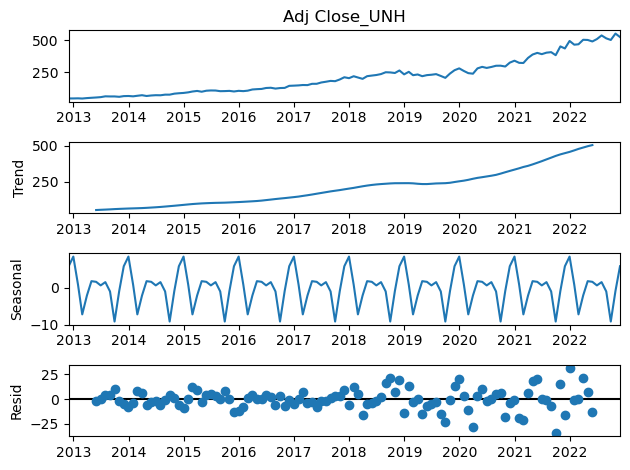

In [30]:
decompose = seasonal_decompose(m_adj(stocks_names[0]))
decompose.plot();

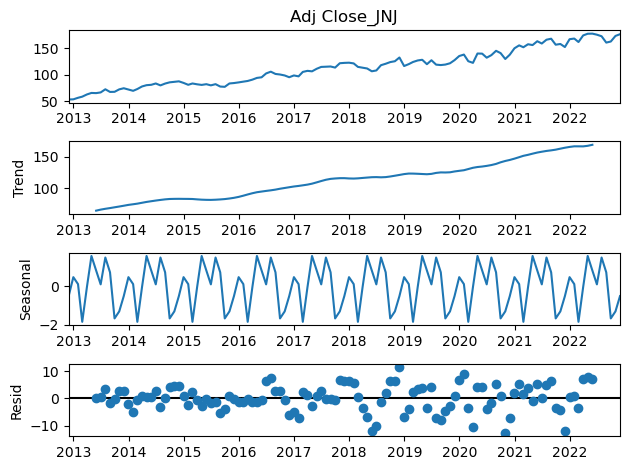

In [31]:
decompose = seasonal_decompose(m_adj(stocks_names[1]))
decompose.plot();

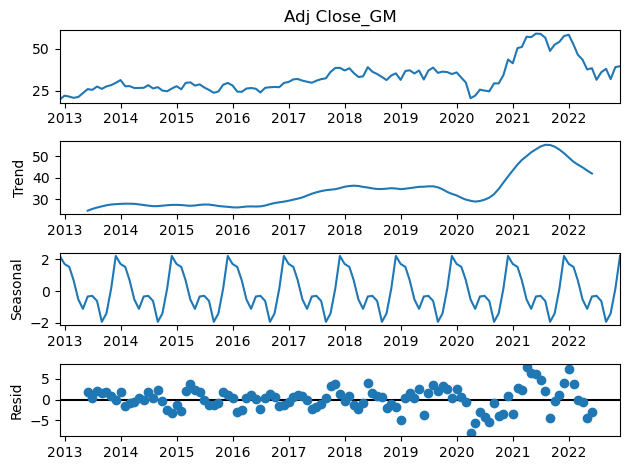

In [32]:
decompose = seasonal_decompose(m_adj(stocks_names[2]))
decompose.plot();

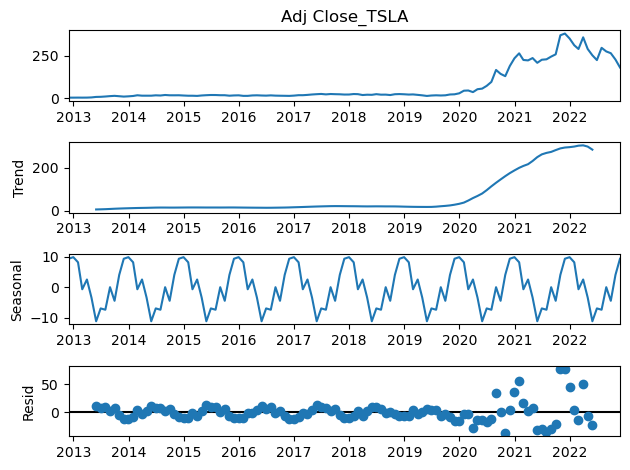

In [33]:
decompose = seasonal_decompose(m_adj(stocks_names[3]))
decompose.plot();

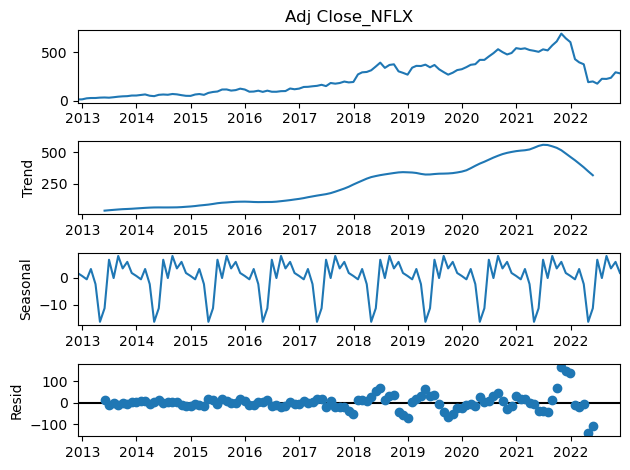

In [34]:
decompose = seasonal_decompose(m_adj(stocks_names[4]))
decompose.plot();

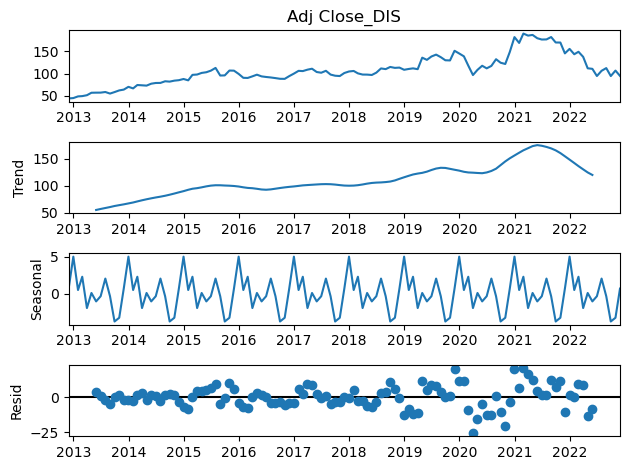

In [35]:
decompose = seasonal_decompose(m_adj(stocks_names[5]))
decompose.plot();

### Grid search

In [36]:
hyperparams = dict([])

for name in stocks_names:

    hyperparams.update({name:arima_grid_search(m_adj(name)[:110], 12)}) # training + validation
    
print("OK!")

OK!


In [37]:
pp = pprint.PrettyPrinter(sort_dicts=False)
pp.pprint(hyperparams)

# AIC, order, seasonal_oder

{'UNH': (797.8605406610347, (1, 1, 0), (1, 1, 0, 12)),
 'JNJ': (625.1276013273365, (1, 1, 1), (0, 1, 1, 12)),
 'GM': (493.28287990395756, (0, 1, 0), (1, 1, 1, 12)),
 'TSLA': (844.2915014692462, (1, 1, 1), (1, 1, 0, 12)),
 'NFLX': (923.686712000156, (0, 1, 0), (0, 1, 1, 12)),
 'DIS': (717.5213674089003, (0, 1, 0), (0, 1, 1, 12))}


### Creazione e fit modelli SARIMAX

In [38]:
models = dict([])

for name in stocks_names:
    training_set = m_adj(name)[:80]
    
    model_results = SARIMAX(
        training_set,
        order=hyperparams.get(name)[1],
        seasonal_order=hyperparams.get(name)[2]
    ).fit()
    
    models.update({name:model_results})
    
print("OK!")

OK!


In [39]:
# summary

for (k,v) in models.items():
    print("==== SUMMARY " + k + " ====\n")
    print(v.summary())
    print("\n\n\n\n\n")

==== SUMMARY UNH ====

                                     SARIMAX Results                                      
Dep. Variable:                      Adj Close_UNH   No. Observations:                   80
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -235.878
Date:                            Thu, 19 Jan 2023   AIC                            477.756
Time:                                    18:25:16   BIC                            484.370
Sample:                                11-30-2012   HQIC                           480.374
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3653      0.123     -2.964      0.003      -0.607      -0.124
ar.S.L12    

### Residui standardizzati

#### Residui UNH

In [40]:
name = stocks_names[0] # UNH

print("Residui " + name)

models.get(name).resid.describe()

Residui UNH


count    80.000000
mean      0.342531
std       9.422260
min     -27.411960
25%      -2.963659
50%       0.832580
75%       3.928460
max      46.453590
dtype: float64

Residui UNH


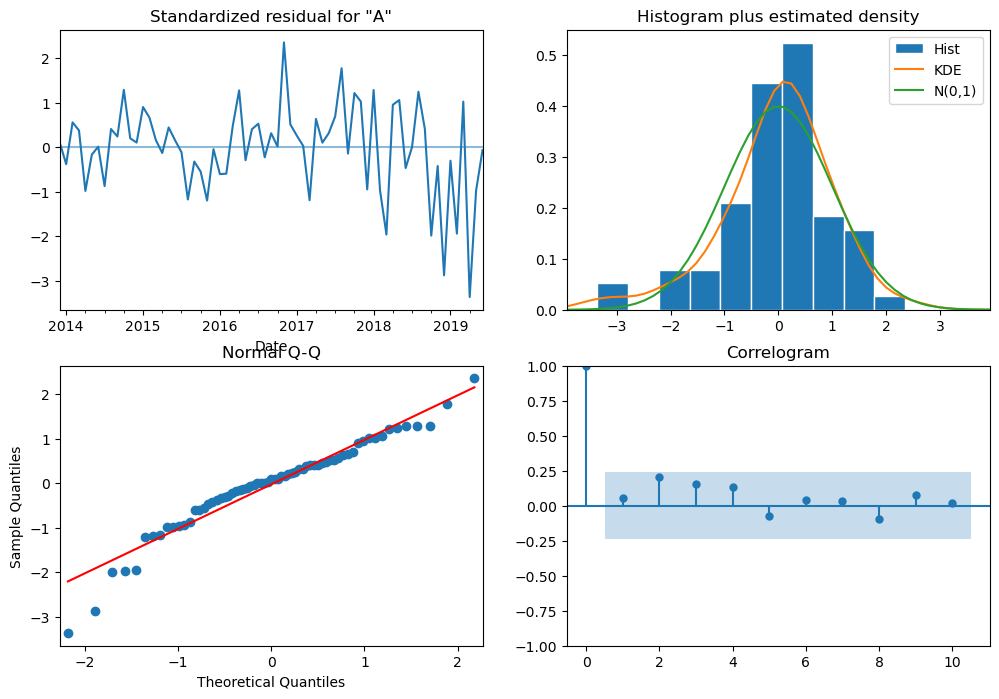

In [41]:
print("Residui " + name)
models.get(name).plot_diagnostics(figsize=(12, 8));

#### Residui JNJ

In [42]:
name = stocks_names[1] # JNJ

print("Residui " + name)

models.get(name).resid.describe()

Residui JNJ


count    80.000000
mean      0.222267
std       7.815700
min     -24.443834
25%      -2.395327
50%       0.372770
75%       2.849161
max      53.113277
dtype: float64

Residui JNJ


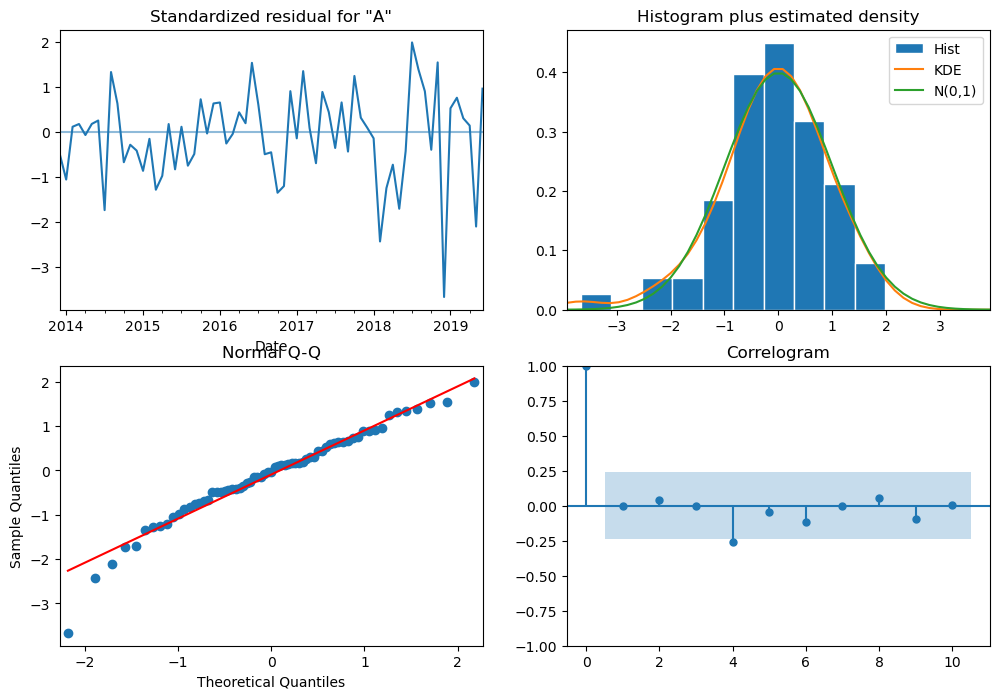

In [43]:
print("Residui " + name)
models.get(name).plot_diagnostics(figsize=(12, 8));

#### Residui GM

In [44]:
name = stocks_names[2] # GM

print("Residui " + name)

models.get(name).resid.describe()

Residui GM


count    80.000000
mean      0.094414
std       3.390688
min      -8.586729
25%      -1.539074
50%      -0.367728
75%       1.473785
max      19.912640
dtype: float64

Residui GM


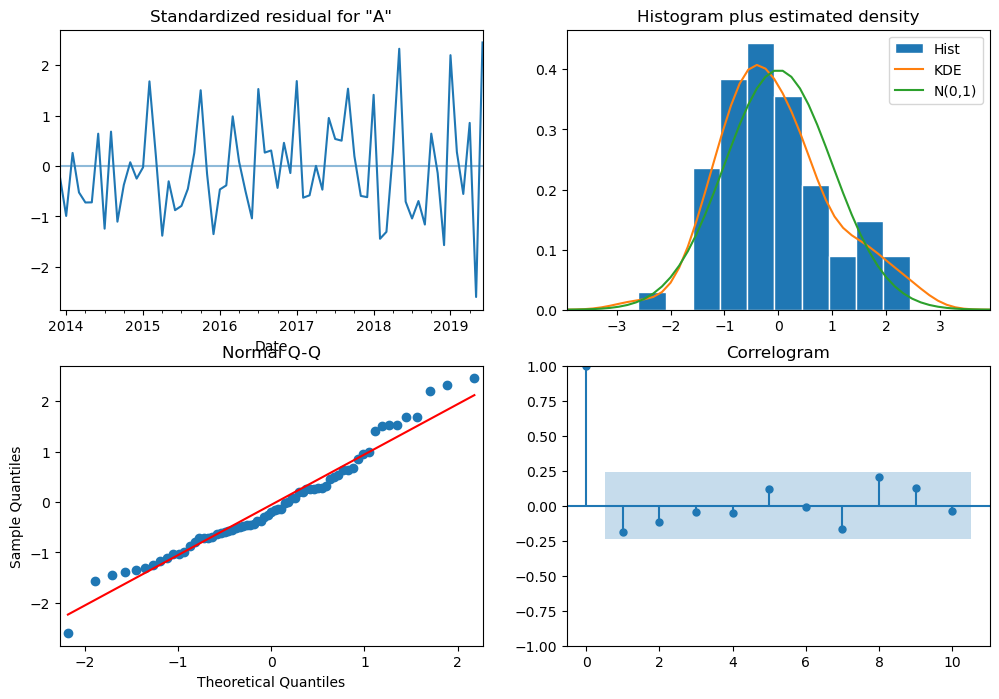

In [45]:
print("Residui " + name)
models.get(name).plot_diagnostics(figsize=(12, 8));

#### Residui TSLA

In [46]:
name = stocks_names[3] # TSLA

print("Residui " + name)

models.get(name).resid.describe()

Residui TSLA


count    80.000000
mean     -0.158127
std       2.393759
min      -7.215001
25%      -1.806203
50%       0.077097
75%       1.627004
max       5.238492
dtype: float64

Residui TSLA


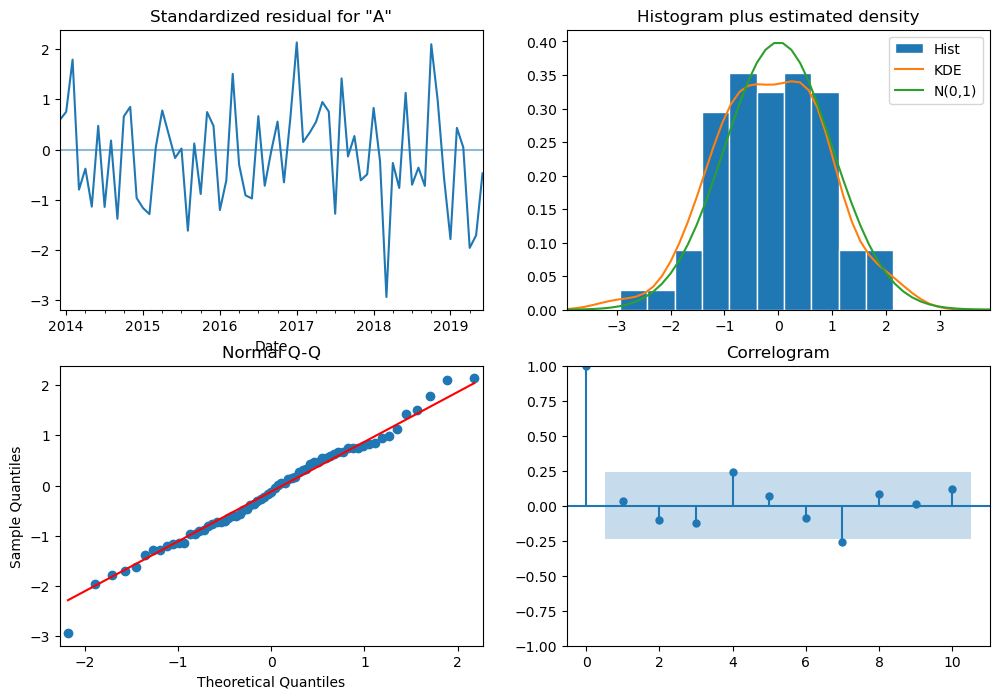

In [47]:
print("Residui " + name)
models.get(name).plot_diagnostics(figsize=(12, 8));

#### Residui NFLX

In [48]:
name = stocks_names[4] # NFLX

print("Residui " + name)

models.get(name).resid.describe()

Residui NFLX


count    80.000000
mean      1.217919
std      20.890812
min     -85.918685
25%      -7.340535
50%       2.069094
75%       9.201621
max      73.130393
dtype: float64

Residui NFLX


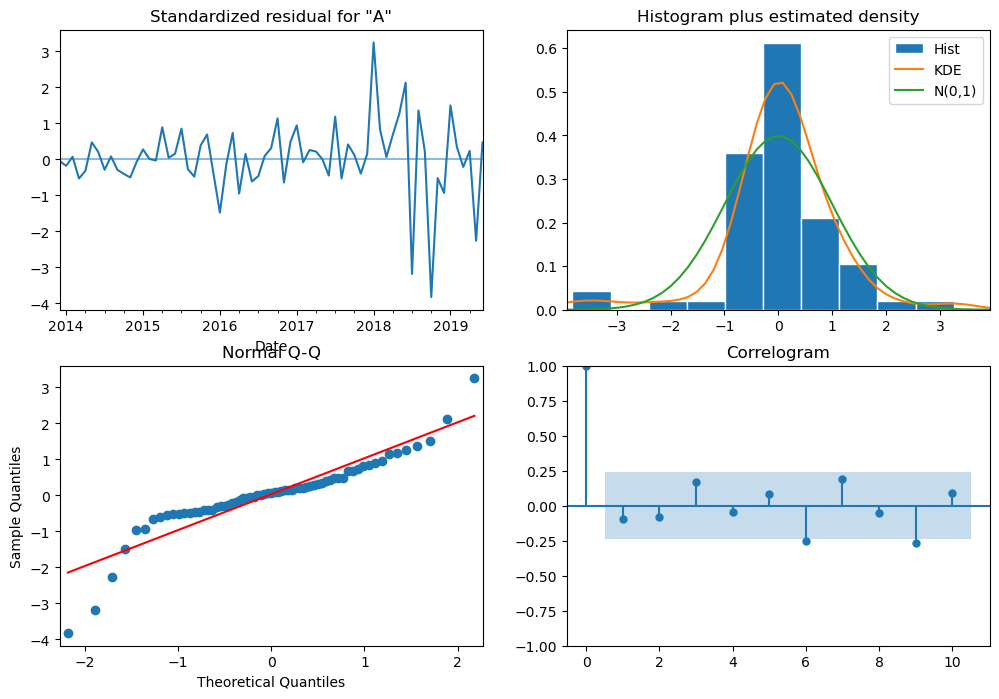

In [49]:
print("Residui " + name)
models.get(name).plot_diagnostics(figsize=(12, 8));

#### Residui DIS

In [50]:
name = stocks_names[5] # DIS

print("Residui " + name)

models.get(name).resid.describe()

Residui DIS


count    80.000000
mean      0.346632
std       7.804126
min     -20.458662
25%      -3.453607
50%       0.093185
75%       3.815384
max      44.462769
dtype: float64

Residui DIS


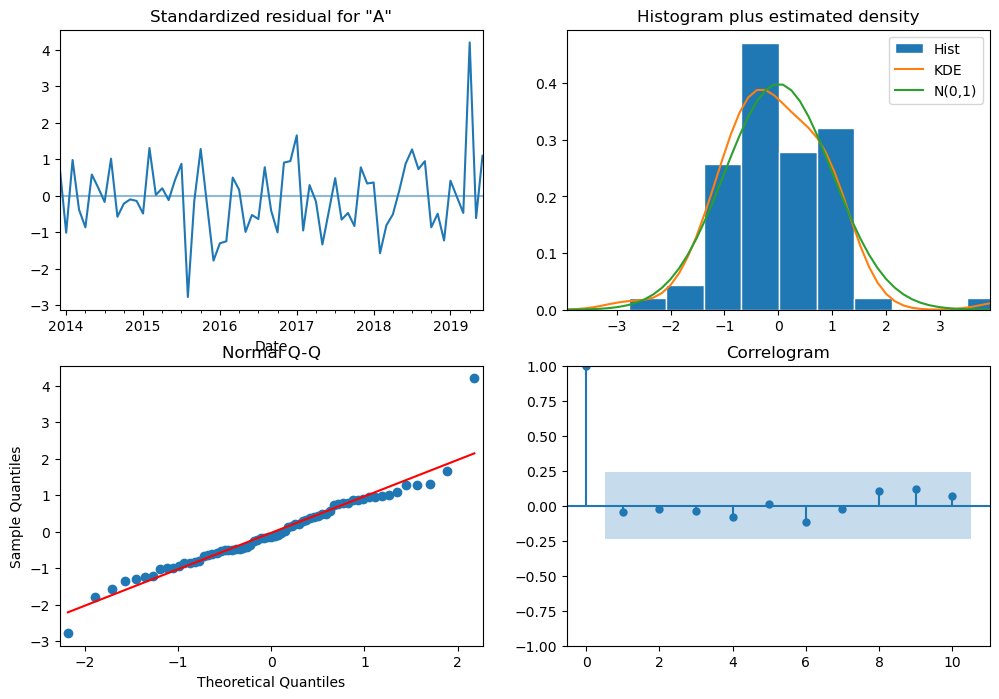

In [51]:
print("Residui " + name)
models.get(name).plot_diagnostics(figsize=(12, 8));

### Predizioni su ultimi 10 mesi

In [52]:
predictions_ic = dict([]) # intervalli di confidenza
forecasted_vals = dict([]) # valori

for name in stocks_names:
    prediction_ci = models.get(name).get_prediction(start=110, end = 110+9).conf_int() # i.c. di 10 predizioni
    forecasted_val = models.get(name).predict(start=110, end = 110+9) # valori forecasted per gli ultimi 10 mesi
    
    predictions_ic.update({name:prediction_ci})
    forecasted_vals.update({name:forecasted_val})

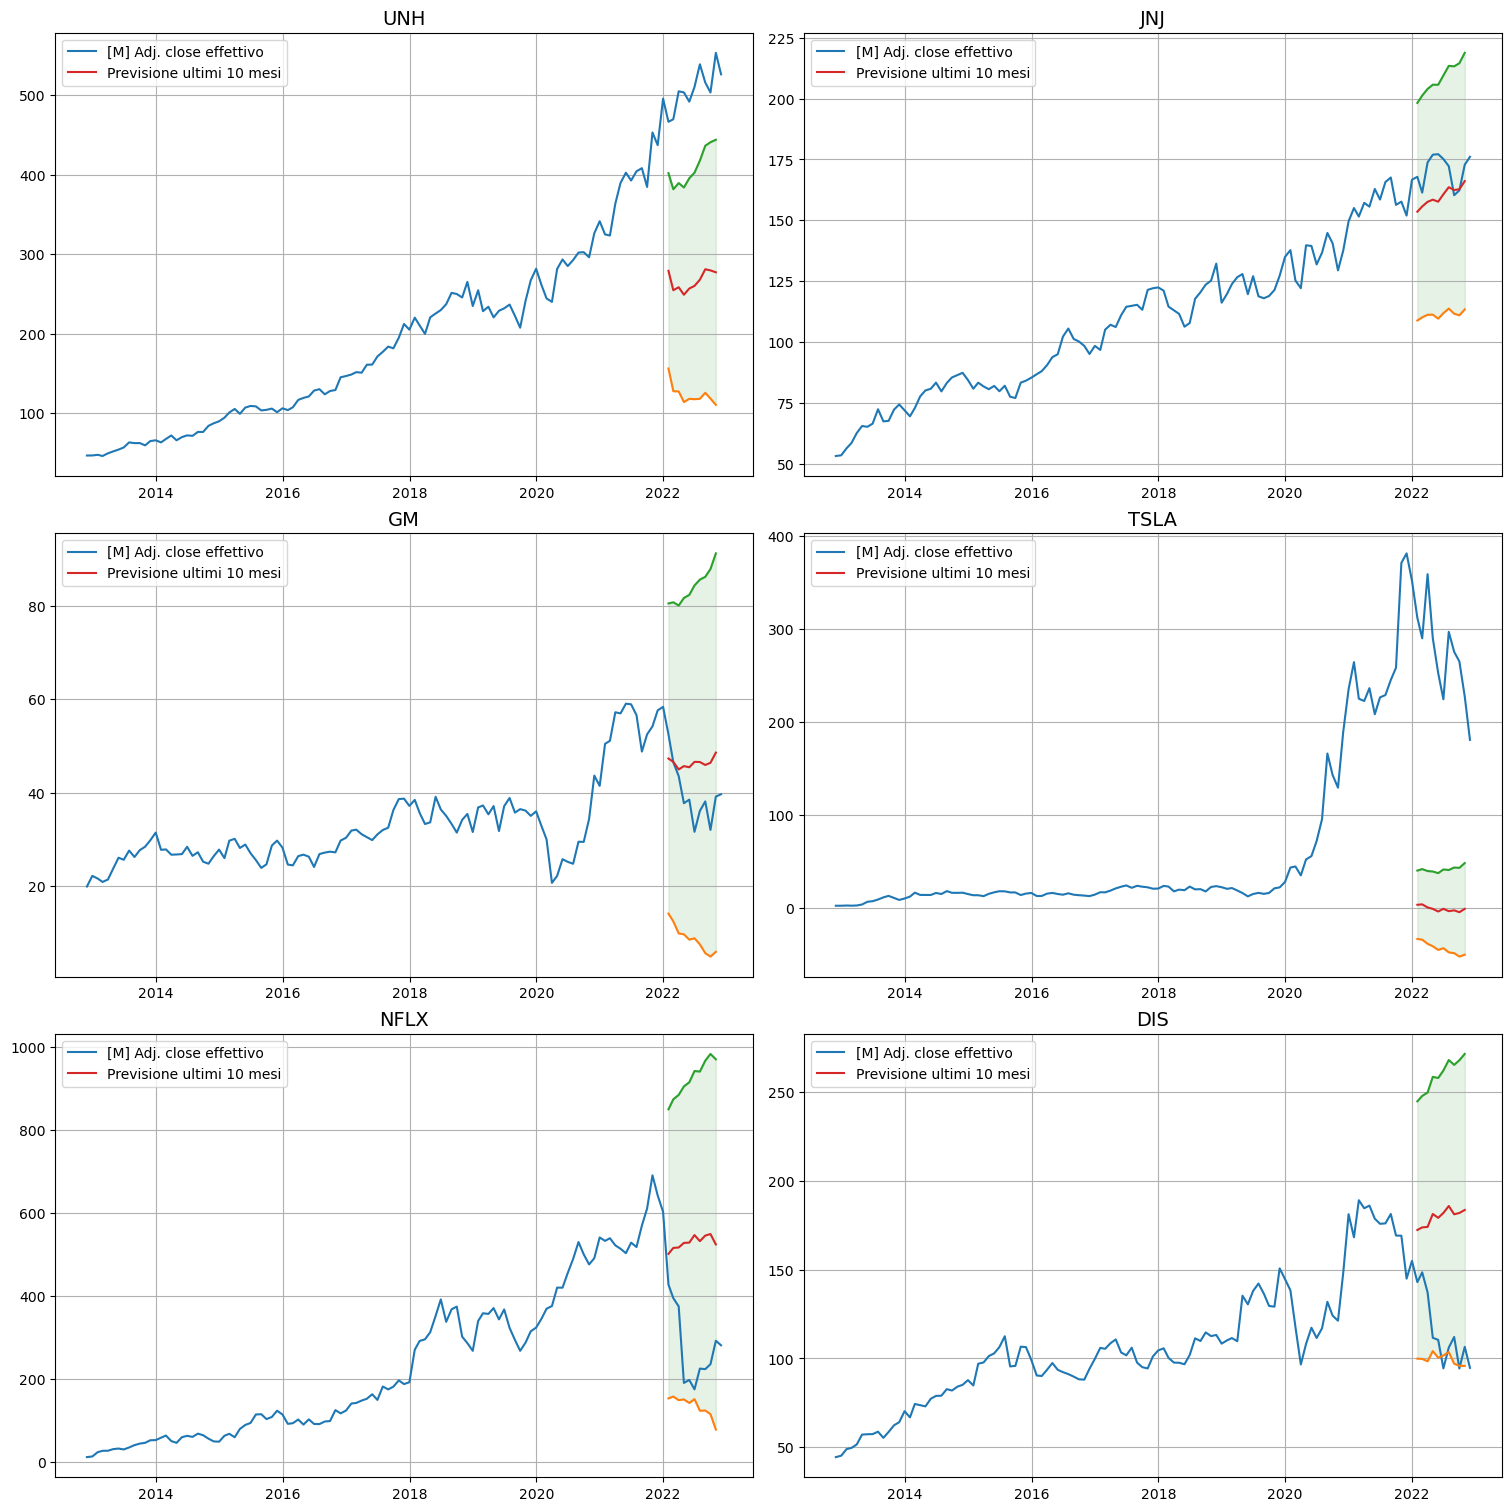

In [53]:
(row, col) = (0, 0)

fig, axs = plt.subplots(3, 2, figsize=(15, 15), constrained_layout = True)

for name in stocks_names:
    ax = axs[row, col]
        
    col += 1
    if col == 2:
        col = 0
        row += 1
        
    ax.set_title(name, fontsize=14)
    
    ax.plot(m_adj(name), label = '[M] Adj. close effettivo')
    
    # intervallo di confidenza
    ax.plot(predictions_ic.get(name))
    ax.fill_between(predictions_ic.get(name).index, 
                    predictions_ic.get(name).iloc[:,0], 
                    predictions_ic.get(name).iloc[:,1], 
                    color = 'g', alpha = 0.1)
    
    # forecast ultimi 10 mesi
    ax.plot(forecasted_vals.get(name), label='Previsione ultimi 10 mesi')
    
    
    ax.grid()
    ax.legend()

### Calcolo di MSE e RMSE, ultimi 10 mesi

In [54]:
# mse e rmse

for name in stocks_names:
    print("------- MSE e RMSE " + name + " -------\n")
    mse = mean_squared_error(m_adj(name)[-10:], forecasted_vals.get(name))
    rmse = sqrt(mse)
    
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    
    print("\n\n")

------- MSE e RMSE UNH -------

MSE:  60901.35863142817
RMSE:  246.78200629589705



------- MSE e RMSE JNJ -------

MSE:  176.79941500899147
RMSE:  13.29659411311752



------- MSE e RMSE GM -------

MSE:  81.06585965175296
RMSE:  9.003658126103687



------- MSE e RMSE TSLA -------

MSE:  73501.06901435158
RMSE:  271.11080578676973



------- MSE e RMSE NFLX -------

MSE:  79061.61716192737
RMSE:  281.17897709808847



------- MSE e RMSE DIS -------

MSE:  5028.2322078625175
RMSE:  70.91002896531997





## 4. Strategie di trading e backtesting

Utilizzo le bande di bollinger + RSI.
    
- Quando il prezzo esce dalla banda superiore e poi vi rientra + RSI > 70 si ha un segnale di vendita (overbought)
- Quando esce dalla banda inferiore e successivamente rientra + RSI < 30 ho un segnale di acquisto (oversold)

In [55]:
# asset che utilizzo

name = 'GM'

# parametri per gli indicatori

# BB
G = 20
F = 2

# RSI
rsi_upper = 70
rsi_lower = 30

# preparazione dataframe

data = pd.DataFrame()

data['Adj Close'] = adj_closes['Adj Close_' + name]

# calcolo BB

rolling = data['Adj Close'].rolling(G)

data['upper_band'] = rolling.mean() + F * rolling.std()
data['lower_band'] = rolling.mean() - F * rolling.std()

# calcolo RSI

delta = data['Adj Close'].diff(1)
up = delta.copy()
down = delta.copy()

up[up < 0] = 0
down[down > 0] = 0

avg_gain = up.rolling(window = G).mean()

avg_loss = abs(down.rolling(window = G).mean())

rs = avg_gain / avg_loss

data['rsi'] = 100.0 - (100.0 / (1.0 + rs))

In [56]:
data.tail()

Adj Close  upper_band  lower_band        rsi
Date                                                    
2022-11-22  39.881310   40.721173   37.444993  60.787180
2022-11-23  40.021000   40.762433   37.628235  58.647205
2022-11-25  40.370220   40.867922   37.752235  58.805510
2022-11-28  39.292618   40.873129   37.799911  51.970274
2022-11-29  39.661797   40.902398   37.820530  51.862890

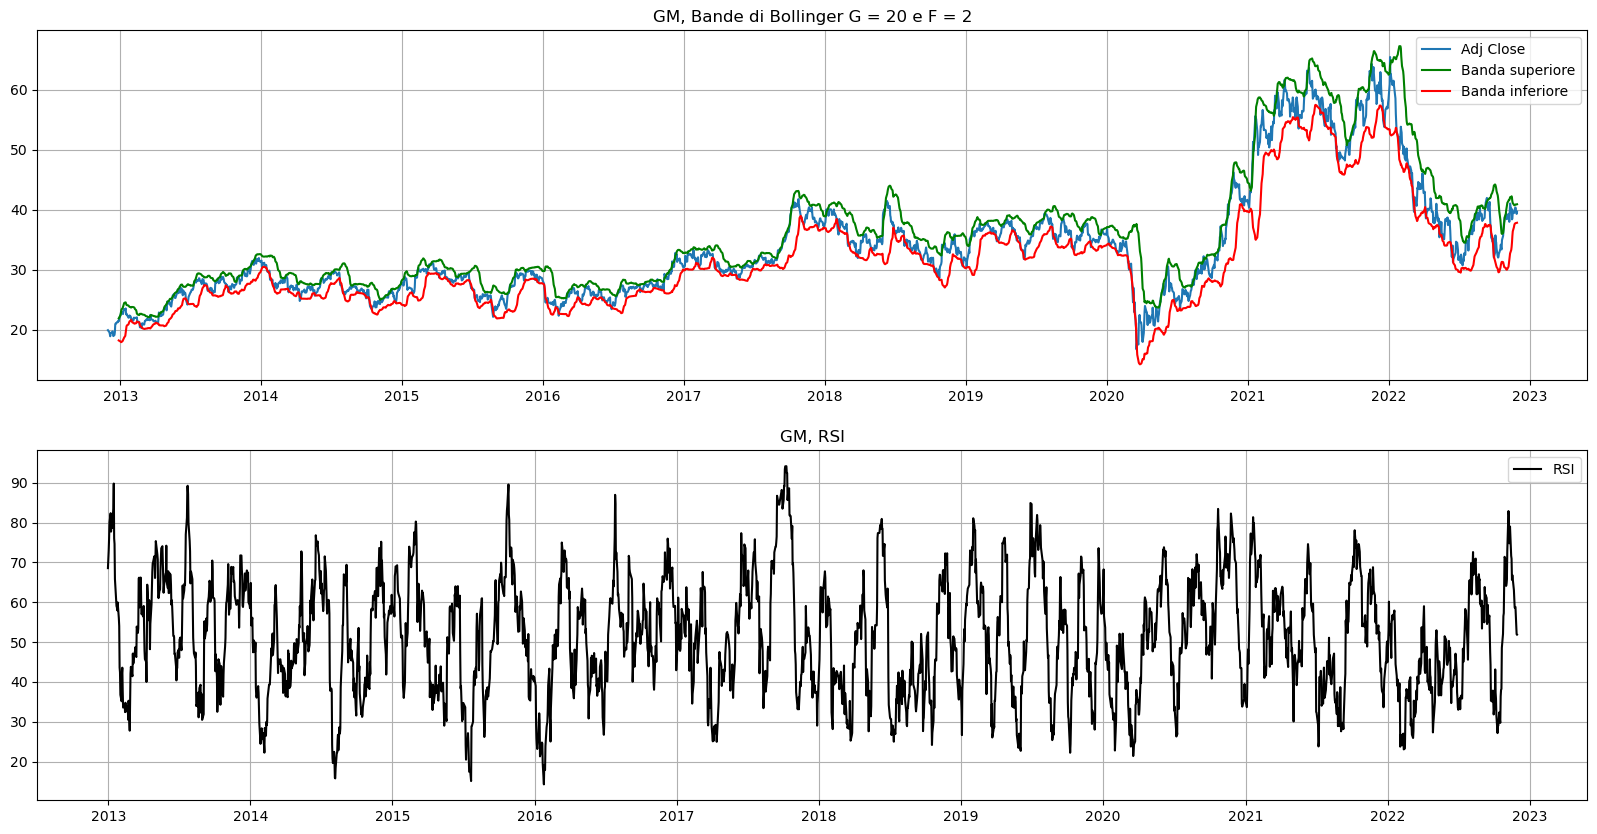

In [57]:
plt.figure(figsize=(20,10))

plt.subplot(211)
plt.title(name + ', Bande di Bollinger G = ' + str(G) + ' e F = ' + str(F))
plt.plot(data['Adj Close'], label = 'Adj Close')
plt.plot(data['upper_band'], label = 'Banda superiore', color = 'g')
plt.plot(data['lower_band'], label = 'Banda inferiore', color = 'r')
plt.grid()
plt.legend()

plt.subplot(212)
plt.title(name + ', RSI')
plt.plot(data['rsi'], label = 'RSI', color = 'k')
plt.grid()
plt.legend();

In [58]:
# backtesting

# acquisto
data['signal'] = np.where(((data['rsi'] < rsi_lower) 
                           & (data['Adj Close'] < data['lower_band']) 
                           & (data['Adj Close'].shift(1) > data['lower_band'])),
                          1, 0)

# vendita
data['signal'] = np.where((data['rsi'] > rsi_upper)
                          & (data['Adj Close'] > data['upper_band']) 
                          & (data['Adj Close'].shift(1) < data['upper_band']),
                          -1, data['signal'])

# posizioni, rimpiazzo gli 0 con il primo valore precedente diverso da 0
data['position'] = data['signal'].replace(to_replace=0, method='ffill')

# shift perche' poi calcolo i rendimenti
data['position'] = data['position'].shift(1)

print("Segnale (1 = buy, -1 = sell) e numero di segnali di quel tipo:")
data['signal'].value_counts()

Segnale (1 = buy, -1 = sell) e numero di segnali di quel tipo:


 0    2463
-1      30
 1      24
Name: signal, dtype: int64

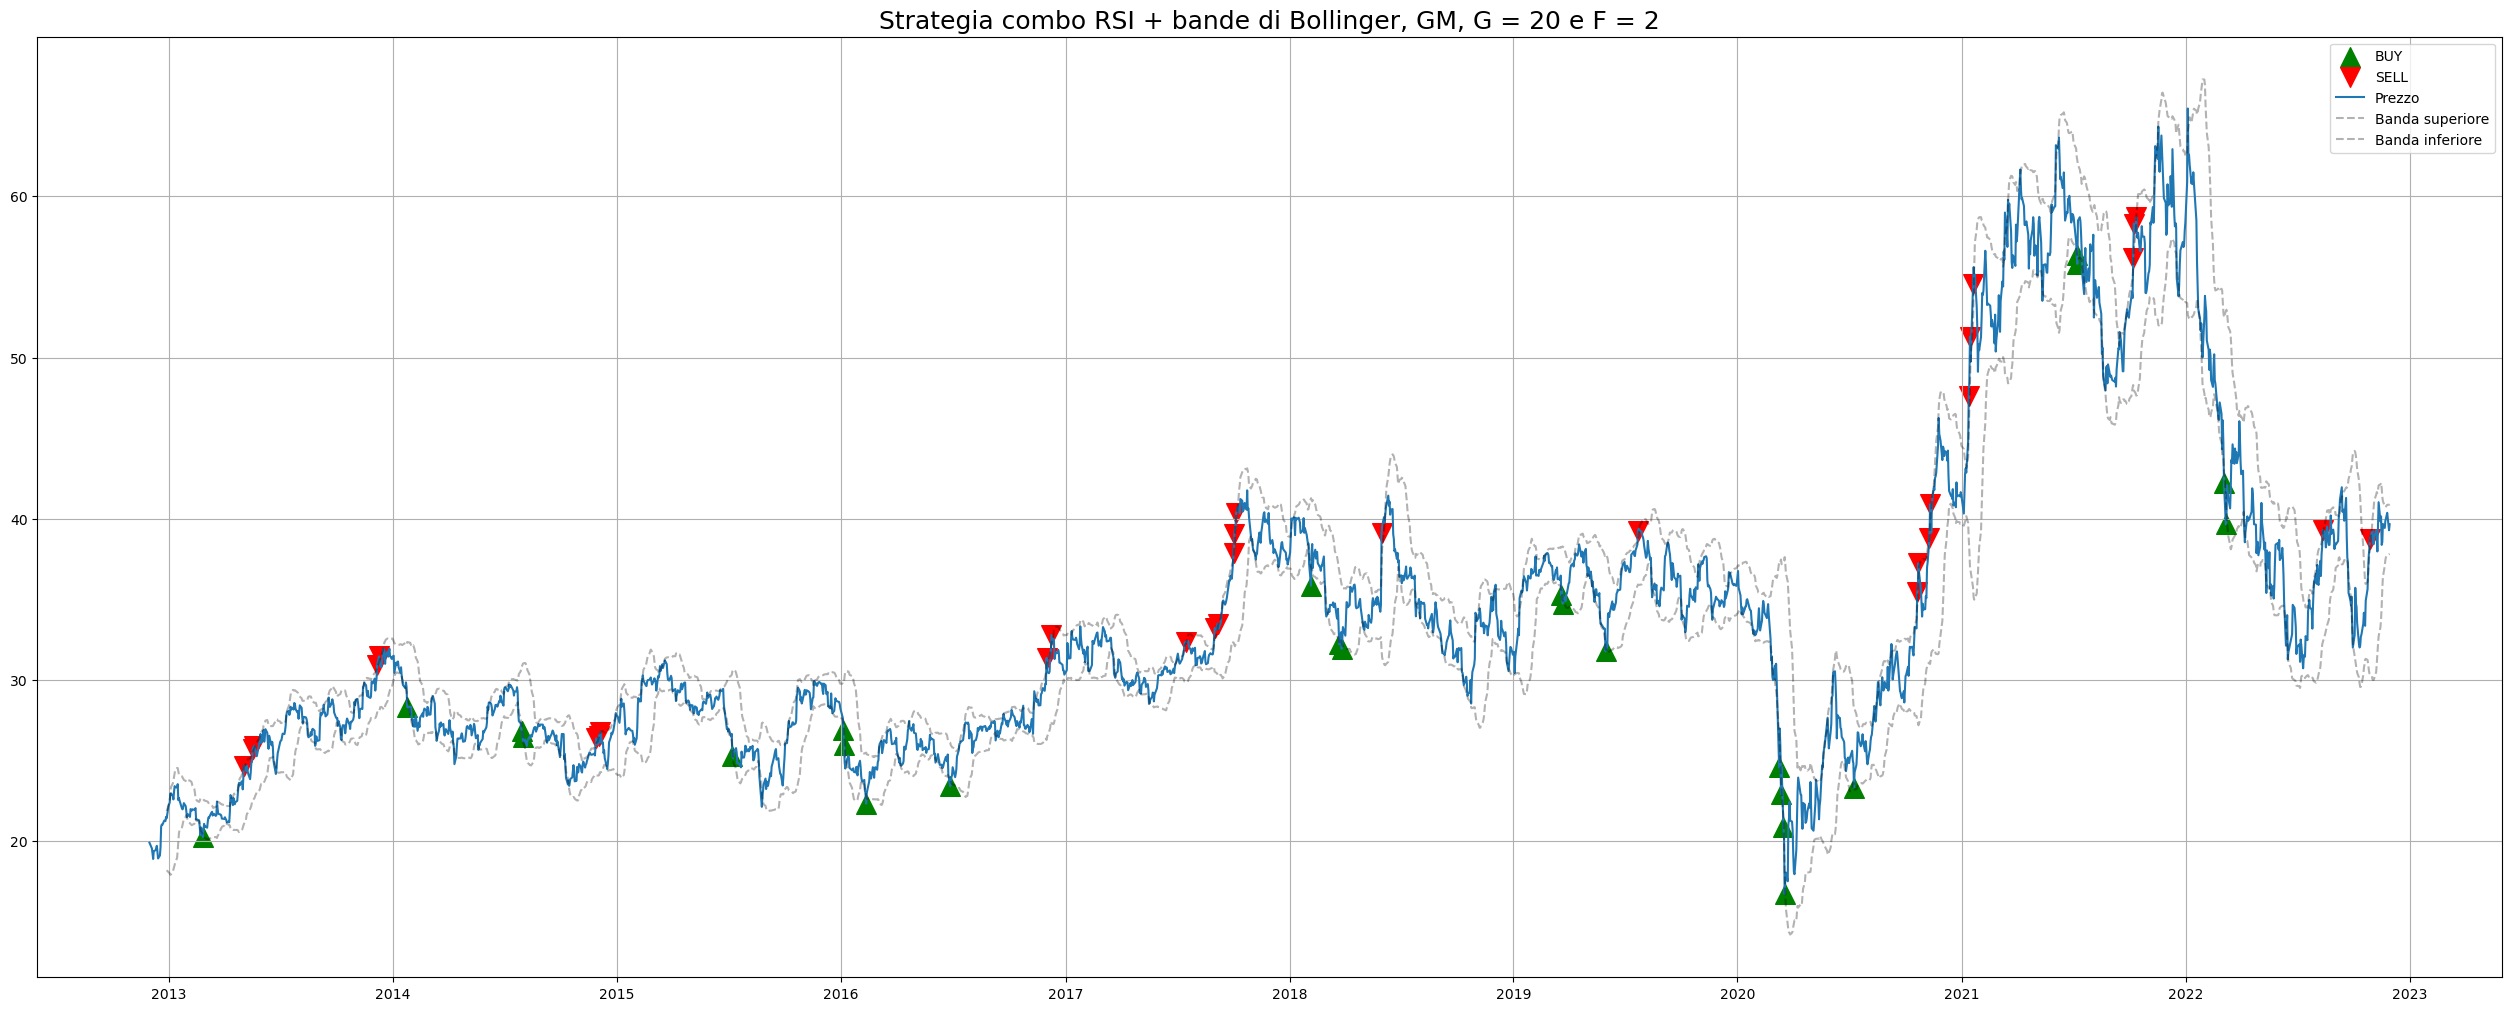

In [59]:
# plot segnali

data['buy_price'] = np.where((data['signal'] == 1), data['Adj Close'], np.nan)
data['sell_price'] = np.where((data['signal'] == -1), data['Adj Close'], np.nan)


plt.figure(figsize=(25,10), constrained_layout = True)
plt.title('Strategia combo RSI + bande di Bollinger, ' + name + ', G = ' + str(G) + ' e F = ' + str(F), fontsize=18)

plt.scatter(data.index, data['buy_price'], marker = '^', color = 'g', label = 'BUY', s = 200)
plt.scatter(data.index, data['sell_price'], marker = 'v', color = 'r', label = 'SELL', s = 200)


plt.plot(data['Adj Close'], label = 'Prezzo')
plt.plot(data['upper_band'], label = 'Banda superiore', color = 'k', linestyle = '--', alpha = 0.3)
plt.plot(data['lower_band'], label = 'Banda inferiore', color = 'k', linestyle = '--', alpha = 0.3)


plt.grid()
plt.legend();

Rendimenti della strategia e confronto con Buy & Hold

In [60]:
data['strategy_returns'] = simple_ret['[D] Simple ret. ' + name] * data['position']

data['buy_and_hold'] = (1 + simple_ret['[D] Simple ret. ' + name]).cumprod()

data['strategy'] = (1 + data['strategy_returns']).cumprod()

cum_rets = data[['buy_and_hold', 'strategy']]

cum_rets.tail()

buy_and_hold  strategy
Date                              
2022-11-22      2.002814  1.622655
2022-11-23      2.009829  1.616972
2022-11-25      2.027367  1.602862
2022-11-28      1.973250  1.645647
2022-11-29      1.991790  1.630185

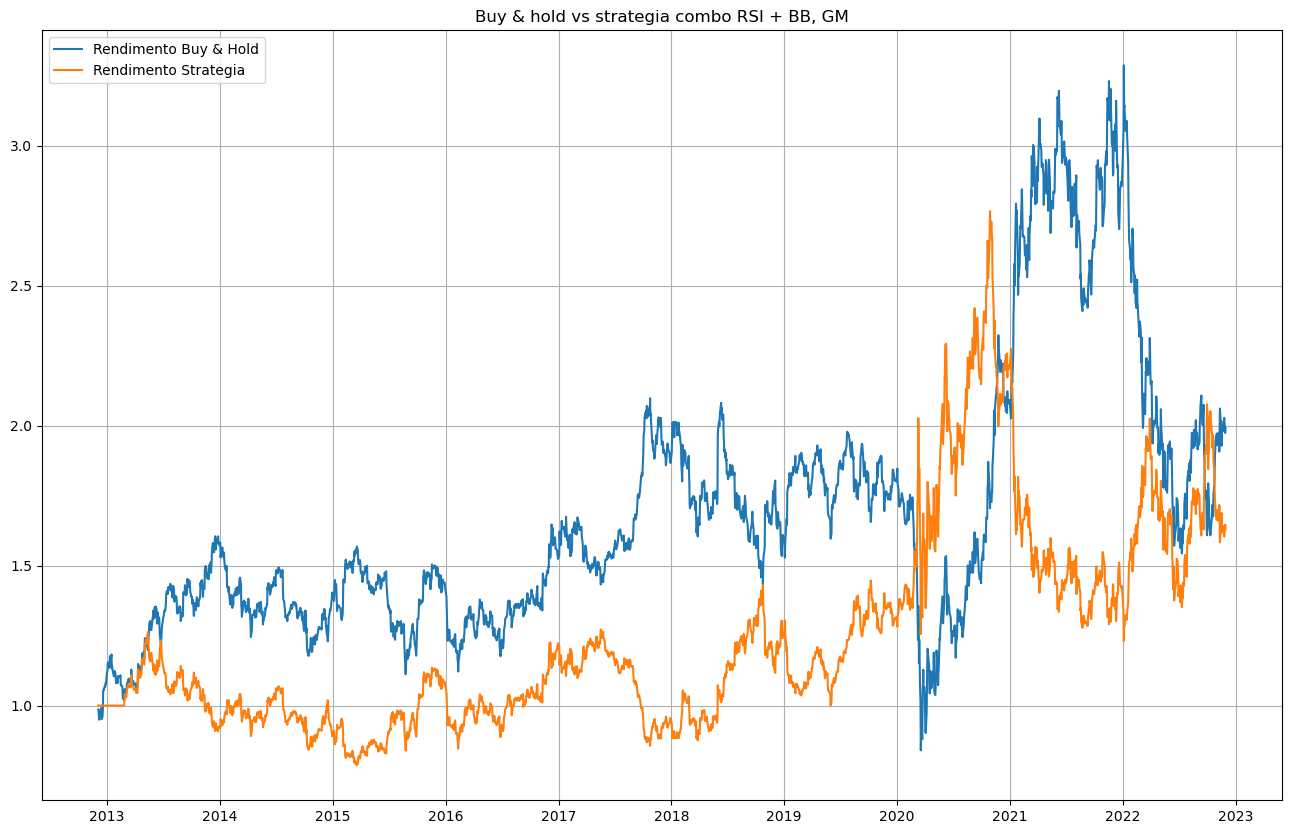

In [61]:
plt.figure(figsize=(16,10))
plt.title('Buy & hold vs strategia combo RSI + BB, ' + name)
plt.plot(cum_rets)
plt.legend(['Rendimento Buy & Hold', 'Rendimento Strategia'])
plt.grid();

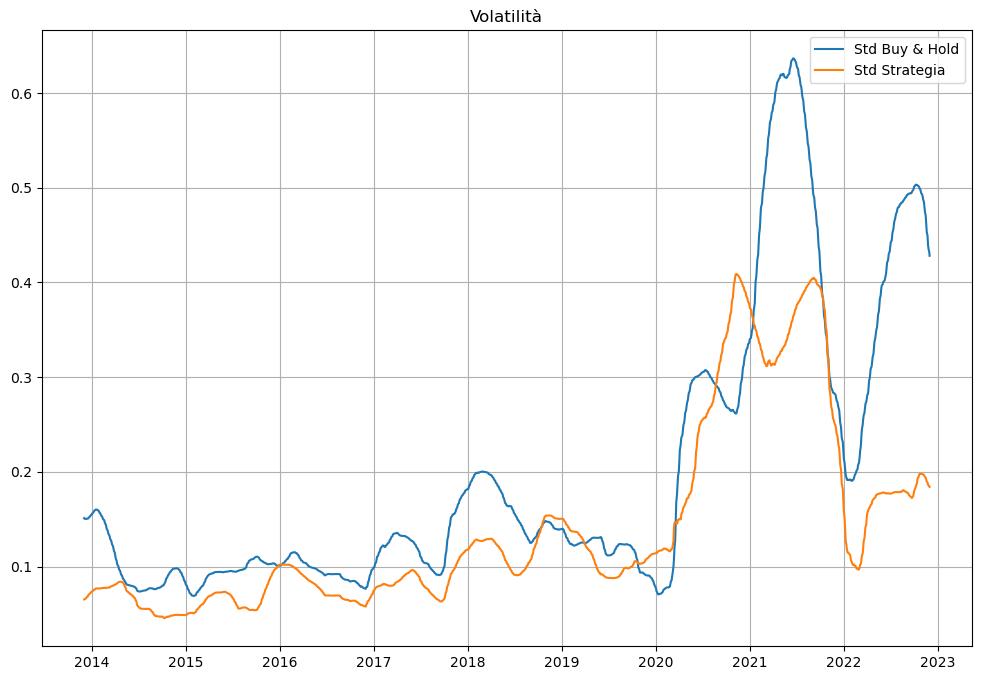

In [62]:
plt.figure(figsize=(12,8))
plt.title('Volatilità')
plt.plot(cum_rets.rolling(252).std())
plt.legend(['Std Buy & Hold', 'Std Strategia'])
plt.grid()

## 5. CAPM

In [63]:
# scarico S&P 500 da yfinance

sp_500 = yf.download('^GSPC', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [64]:
# calcolo i rendimenti semplici mensili di S&P500

m_rtn_market = sp_500['Adj Close'].resample('M').last().pct_change()
m_rtn_market.dropna(inplace=True)

m_rtn_market.head()

Date
2012-12-31    0.007068
2013-01-31    0.050428
2013-02-28    0.011061
2013-03-31    0.035988
2013-04-30    0.018086
Freq: M, Name: Adj Close, dtype: float64

### Calcolo del beta di ciascun titolo

In [65]:
# li salvo in un dizionario per mostrarli dopo in maniera ordinata

betas = dict([])


# salvo anche i rendimenti semplici mensili per dopo

m_rtn = dict([])

for name in stocks_names:
    print("=== " + name + " ===")
    
    m_rtn_asset = m_adj(name).pct_change().dropna()
    
    m_rtn_asset.name = 'rtn_' + name
    
    df_asset_market = pd.DataFrame()
    df_asset_market[name] = m_rtn_asset
    df_asset_market['S&P500'] = m_rtn_market
    
    print("\nDataframe rendimenti semplici mensili:")
    print(df_asset_market.head(5))
    
    print("\nMatrice di covarianze:")
    cov_matrix = df_asset_market.cov()
    print(cov_matrix.head(5))
    
    cov = cov_matrix.loc[name, 'S&P500']
    print("\nCovarianza " + name + " e il mercato (S&P500): ", cov)
    
    var = df_asset_market['S&P500'].var()
    print("\nVarianza del mercato: ", var)
    
    # calcolo di beta
    beta = cov / var
    print("\nBeta: ", beta)
    
    # aggiorno i dict
    betas.update({name:beta})
    m_rtn.update({name:m_rtn_asset})
    
    print("\n\n")

=== UNH ===

Dataframe rendimenti semplici mensili:
                 UNH    S&P500
Date                          
2012-12-31  0.001217  0.007068
2013-01-31  0.017883  0.050428
2013-02-28 -0.031878  0.011061
2013-03-31  0.074500  0.035988
2013-04-30  0.047544  0.018086

Matrice di covarianze:
             UNH    S&P500
UNH     0.003275  0.001276
S&P500  0.001276  0.001760

Covarianza UNH e il mercato (S&P500):  0.0012764942817397175

Varianza del mercato:  0.0017602510433021082

Beta:  0.7251774038691113



=== JNJ ===

Dataframe rendimenti semplici mensili:
                 JNJ    S&P500
Date                          
2012-12-31  0.005306  0.007068
2013-01-31  0.054494  0.050428
2013-02-28  0.037863  0.011061
2013-03-31  0.071213  0.035988
2013-04-30  0.045382  0.018086

Matrice di covarianze:
             JNJ    S&P500
JNJ     0.001951  0.001098
S&P500  0.001098  0.001760

Covarianza JNJ e il mercato (S&P500):  0.0010980683456068383

Varianza del mercato:  0.0017602510433021082

Beta:

In [66]:
print("Beta di ciascun titolo rispetto al mercato (S&P500):")

pp.pprint(betas)

Beta di ciascun titolo rispetto al mercato (S&P500):
{'UNH': 0.7251774038691113,
 'JNJ': 0.6238134894366764,
 'GM': 1.360600234470463,
 'TSLA': 1.7465926791682234,
 'NFLX': 1.3127338236947337,
 'DIS': 1.2678714640865798}


### Esposizione di ciascun titolo rispetto ai fattori di rischio Fama-French

In [67]:
# dati scaricati da https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

# carico il csv togliendo le prime 3 righe
factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)

# tolgo la parte annual factors
indices = factor_df.iloc[:,0] == ' Annual Factors: January-December '
factor_df = factor_df[factor_df.index < factor_df[indices].index[0]]

# sistemo le colonne
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']

# da Ym a Y-m per la data
factor_df['date'] = pd.to_datetime(factor_df['date'], format='%Y%m').dt.strftime("%Y-%m")

# diventa l'index del dataframe
factor_df = factor_df.set_index('date')

# intervallo richiesto
factor_df = factor_df['2012-11-30':'2022-11-30']

# divisione per 100
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)

factor_df.head()

mkt     smb     hml      rf
date                                   
2012-12  0.0118  0.0150  0.0351  0.0001
2013-01  0.0557  0.0033  0.0096  0.0000
2013-02  0.0129 -0.0028  0.0011  0.0000
2013-03  0.0403  0.0081 -0.0019  0.0000
2013-04  0.0155 -0.0236  0.0045  0.0000

In [68]:
factor_df.tail()

mkt     smb     hml      rf
date                                   
2022-06 -0.0843  0.0209 -0.0597  0.0006
2022-07  0.0957  0.0281 -0.0410  0.0008
2022-08 -0.0377  0.0139  0.0031  0.0019
2022-09 -0.0935 -0.0082  0.0003  0.0019
2022-10  0.0783  0.0010  0.0806  0.0023

In [69]:
# MODELLO A TRE FATTORI per ogni titolo
# i parametri mkt, smb e hml sono mostrati nel summary del modello OLS

for name in stocks_names:
    
    print("=====  " + name + "  =====")
    
    # ritorni semplici mensili dell'asset
    m_rtn_asset = m_rtn.get(name).copy()
    m_rtn_asset.index = m_rtn_asset.index.strftime('%Y-%m')
    m_rtn_asset.name = 'rtn_' + name
    
    # concatenazione e calcolo rendimenti in eccesso rispetto al risk free
    ff_df = pd.concat([factor_df, m_rtn_asset.to_frame()], axis=1)
    ff_df['excess_rtn_' + name] = ff_df['rtn_' + name] - ff_df['rf']
    
    print("\nDataframe dato dall'unione tra i dati F-F e " + name + ":\n")
    print(ff_df.head(5))
    
    print("\nMODELLO A TRE FATTORI " + name + ": ")
    # ols = ordinary least squares
    ff_model = smf.ols(formula = 'excess_rtn_' + name + ' ~ mkt + smb + hml', data = ff_df).fit()
    summary = ff_model.summary()
    print(summary)
    
    print("\n\n\n")
    

=====  UNH  =====

Dataframe dato dall'unione tra i dati F-F e UNH:

            mkt     smb     hml      rf   rtn_UNH  excess_rtn_UNH
2012-12  0.0118  0.0150  0.0351  0.0001  0.001217        0.001117
2013-01  0.0557  0.0033  0.0096  0.0000  0.017883        0.017883
2013-02  0.0129 -0.0028  0.0011  0.0000 -0.031878       -0.031878
2013-03  0.0403  0.0081 -0.0019  0.0000  0.074500        0.074500
2013-04  0.0155 -0.0236  0.0045  0.0000  0.047544        0.047544

MODELLO A TRE FATTORI UNH: 
                            OLS Regression Results                            
Dep. Variable:         excess_rtn_UNH   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     15.35
Date:                Thu, 19 Jan 2023   Prob (F-statistic):           1.83e-08
Time:                        18:26:40   Log-Likelihood:                 192.21
No. Observations:               

### Utilizzo del beta per calcolare il rendimento atteso annuo

In [70]:
factor_df.tail()

mkt     smb     hml      rf
date                                   
2022-06 -0.0843  0.0209 -0.0597  0.0006
2022-07  0.0957  0.0281 -0.0410  0.0008
2022-08 -0.0377  0.0139  0.0031  0.0019
2022-09 -0.0935 -0.0082  0.0003  0.0019
2022-10  0.0783  0.0010  0.0806  0.0023

In [71]:
expected_mkt = factor_df.iloc[-12:, 0].mean() * 12 # 12 * (media ultimi 12 mesi colonna 0 = mkt)
expected_rf = factor_df.iloc[-12:, 3].mean() * 12 # 12 * (media ultimi 12 mesi colonna 3 = rf)

print("Tasso risk-free annuo: ", expected_rf)
print("Rendimento atteso annuo di mercato: ", expected_mkt, "\n\n")

m_expected_ret = dict([])

for name in stocks_names:
    tmp = expected_rf + betas.get(name) * (expected_mkt - expected_rf)
    print("Rendimento atteso annuo di " + name + ": " + str(tmp))
    m_expected_ret.update({name:tmp})

Tasso risk-free annuo:  0.0081
Rendimento atteso annuo di mercato:  -0.1789 


Rendimento atteso annuo di UNH: -0.12750817452352384
Rendimento atteso annuo di JNJ: -0.10855312252465849
Rendimento atteso annuo di GM: -0.24633224384597657
Rendimento atteso annuo di TSLA: -0.31851283100445776
Rendimento atteso annuo di NFLX: -0.2373812250309152
Rendimento atteso annuo di DIS: -0.22899196378419043


## 6. Costruzione di portafoglio

In [72]:
# rendimenti passati, primi 108 mesi

ret_df = pd.DataFrame()
for name in stocks_names:
    ret_df = pd.concat([ret_df, m_rtn.get(name)[:108].to_frame()], axis=1)
    
ret_df.tail()

rtn_UNH   rtn_JNJ    rtn_GM  rtn_TSLA  rtn_NFLX   rtn_DIS
Date                                                                  
2021-07-31  0.029418  0.045283 -0.039378  0.011034 -0.020144  0.001422
2021-08-31  0.009825  0.011375 -0.137755  0.070605  0.099735  0.029997
2021-09-30 -0.058036 -0.067175  0.075495  0.054042  0.072296 -0.066906
2021-10-31  0.178456  0.008545  0.032631  0.436530  0.131025 -0.000591
2021-11-30 -0.035290 -0.036399  0.063200  0.027612 -0.070128 -0.142959

In [73]:
def print_portfolio(portfolio, msg):
    print("=== " + msg + " ===")
    print("Rendimento atteso: ", portfolio['returns'])
    print("Volatilità: ", portfolio['volatility'])
    print("Sharpe Ratio: ", portfolio['sharpe_ratio'], "\n")

In [74]:
# inizializzazione
n_portfolio = 10 ** 5
n_period = 12

n_assets = len(stocks_names) # 6

# matrice di covarianze
cov_mat = ret_df.cov() * n_period

### Metodo di simulazione (Monte Carlo), rendimenti passati

In [75]:
# rendimenti
avg_ret = ret_df.mean() * n_period

In [76]:
# pesi casuali
np.random.seed(42)
weights = np.random.random(size=(n_portfolio, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

# rendimenti di portfolio
portfolio_rtn = np.dot(weights, avg_ret)

portfolio_vol = []
for i in range(0, len(weights)):
    portfolio_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portfolio_vol = np.array(portfolio_vol)  

# nuovo df
portfolio_results_df = pd.DataFrame({'returns': portfolio_rtn,
                                 'volatility': portfolio_vol,
                                 'sharpe_ratio': portfolio_rtn / portfolio_vol}) # rf = 0

past_rtn_min = portfolio_results_df.returns.min() # così lo riutilizzo più avanti
past_rtn_max = portfolio_results_df.returns.max()

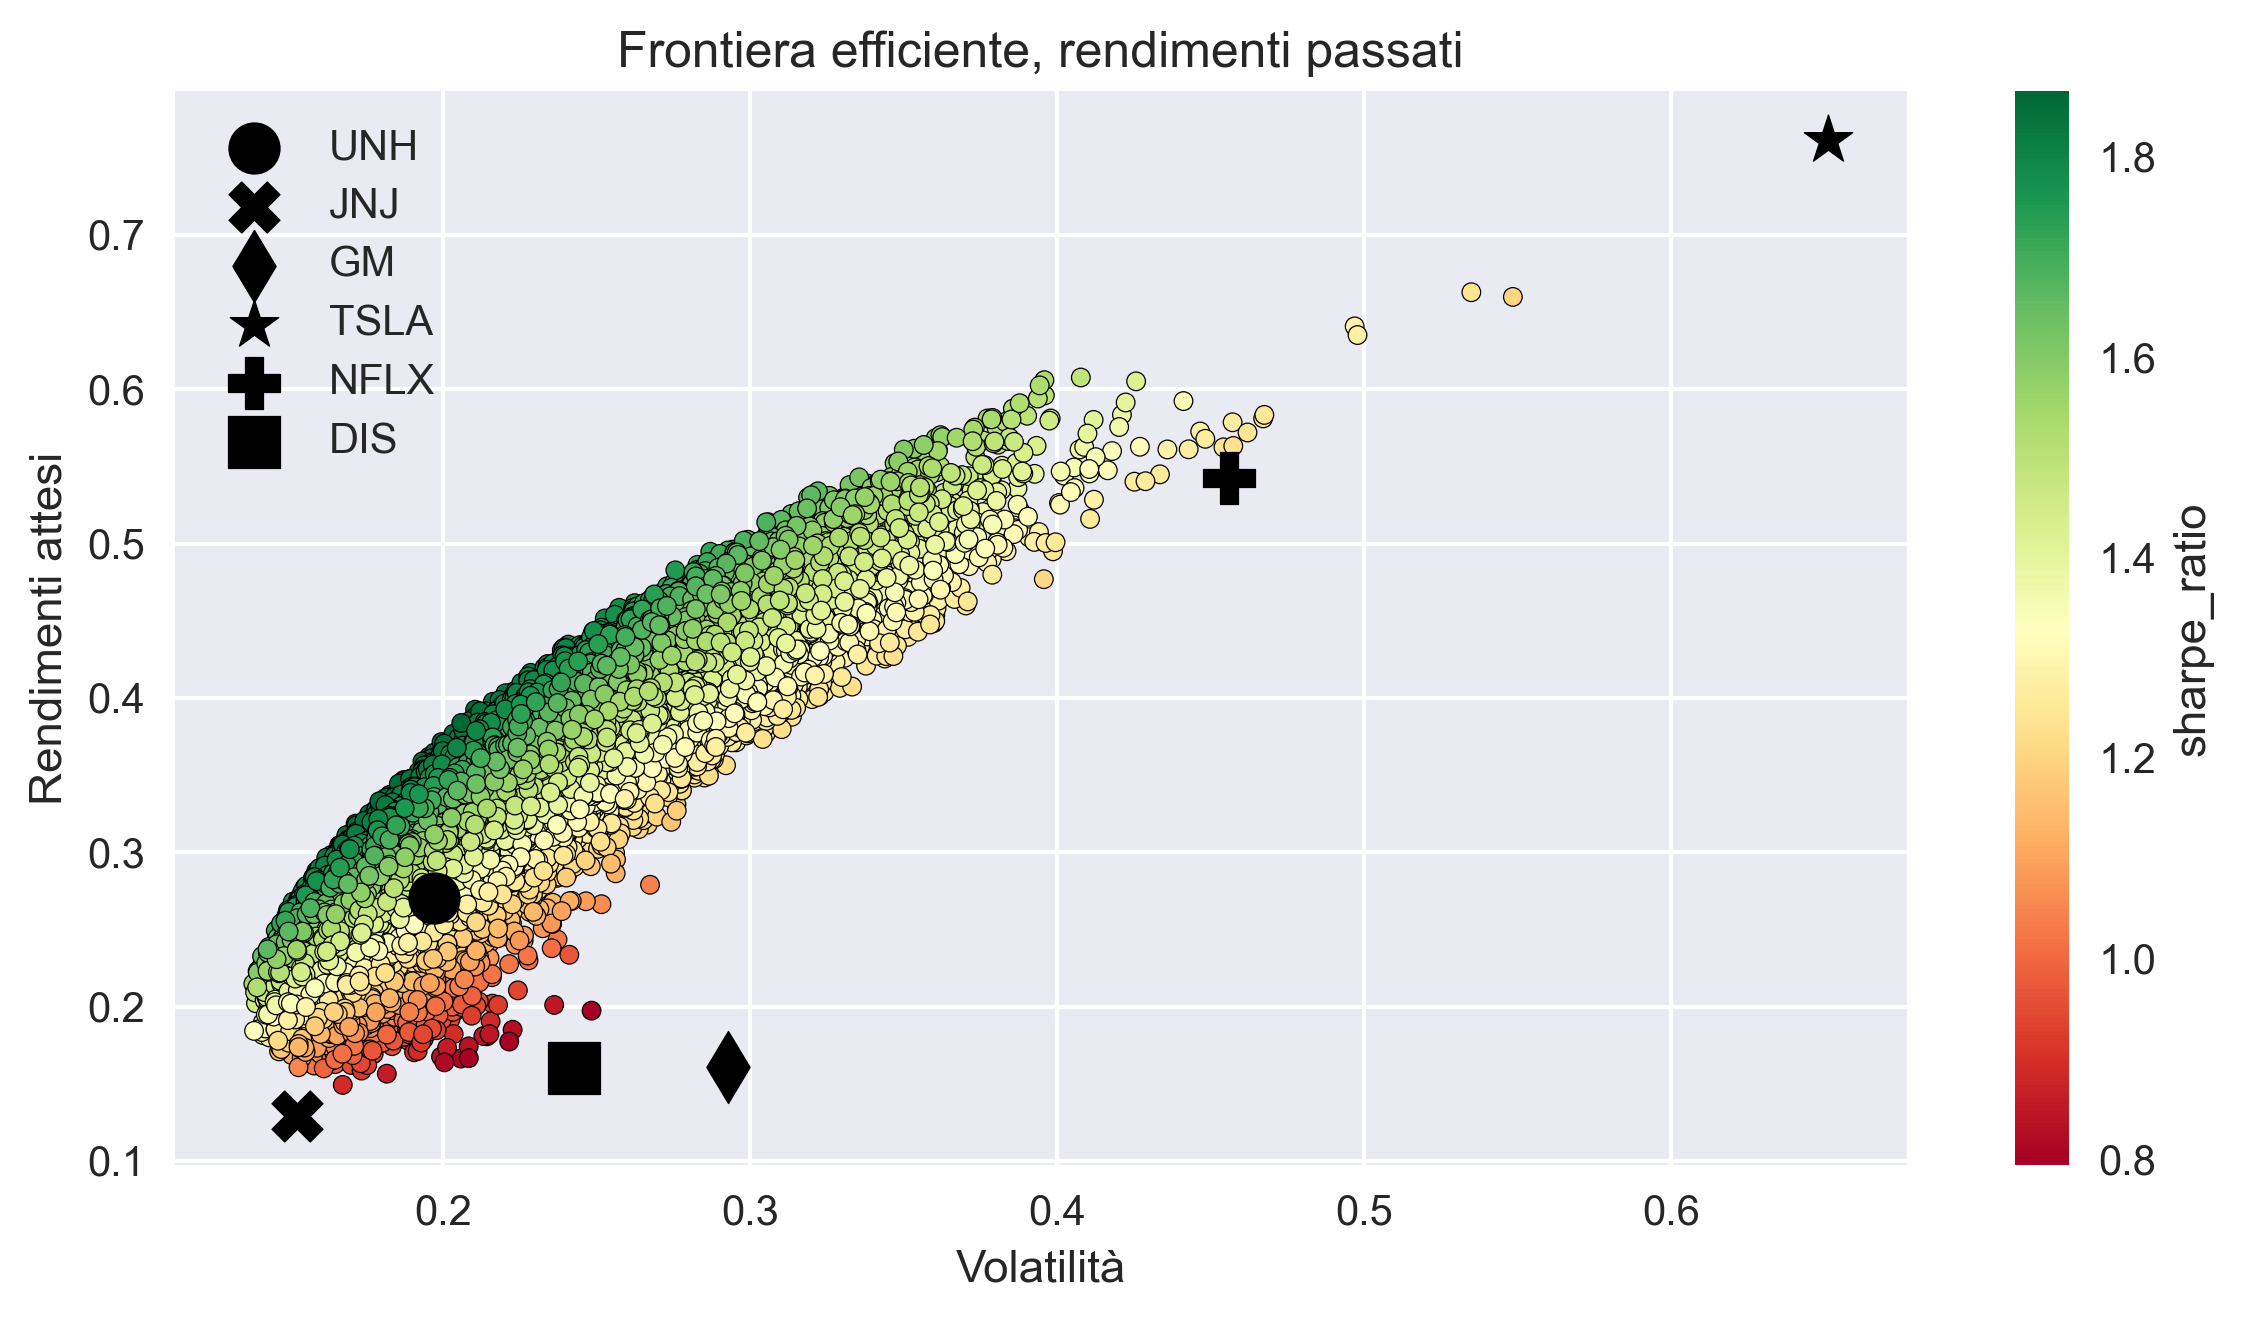

In [77]:
plt.style.use('seaborn')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

MARKS = ['o', 'X', 'd', '*', 'P', 's']

fig, ax = plt.subplots()
portfolio_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatilità', 
       ylabel='Rendimenti attesi', 
       title='Frontiera efficiente, rendimenti passati')

#ax.plot(portfolio_vol_ef, portfolio_rtn_ef, 'b--')

for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), # varianza
                y=avg_ret[asset_index], # media
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=stocks_names[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

In [78]:
# max sharpe ratio

max_sr = np.argmax(portfolio_results_df.sharpe_ratio)
max_sr_portfolio = portfolio_results_df.loc[max_sr]
max_sr_weights = weights[np.argmax(portfolio_results_df.sharpe_ratio)]

print_portfolio(max_sr_portfolio, "Portfolio con sharpe ratio massimo")
print("=== Pesi portfolio con max sr ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_sr_weights[index])

# beta portfolio rispetto al mercato 
# (= somma pesata dei beta degli asset rispetto al mercato = dot product)

beta_max_sr = np.dot(max_sr_weights, list(betas.values()))
    
print("\n=== Beta portfolio con max sr rispetto al mercato ===")
print("Beta: ", beta_max_sr)

    
print("\n\n---------------------------------------------------------------------------\n\n")

# min volatility

min_vol = np.argmin(portfolio_results_df.volatility)
min_vol_portfolio = portfolio_results_df.loc[min_vol]
min_vol_weights = weights[np.argmin(portfolio_results_df.volatility)]

print_portfolio(min_vol_portfolio, "Portfolio con volatilità minima")
print("=== Pesi portfolio con min volatility ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", min_vol_weights[index])

# beta portfolio

beta_min_vol = np.dot(min_vol_weights, list(betas.values()))

print("\n=== Beta portfolio con min volatility rispetto al mercato ===")
print("Beta: ", beta_min_vol)
    

print("\n\n---------------------------------------------------------------------------\n\n")
    
# max returns

max_ret = np.argmax(portfolio_results_df.returns)
max_ret_portfolio = portfolio_results_df.loc[max_ret]
max_ret_weights = weights[np.argmax(portfolio_results_df.returns)]

print_portfolio(max_ret_portfolio, "Portfolio con rendimento massimo")
print("=== Pesi portfolio con max returns ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_ret_weights[index])
    
# beta portfolio

beta_max_ret = np.dot(max_ret_weights, list(betas.values()))
    
print("\n=== Beta portfolio con max returns rispetto al mercato ===")
print("Beta: ", beta_max_ret)

=== Portfolio con sharpe ratio massimo ===
Rendimento atteso:  0.39237105656488735
Volatilità:  0.21042183707201934
Sharpe Ratio:  1.8646879146416433 

=== Pesi portfolio con max sr ===
UNH:  0.5473033331338616
JNJ:  0.057464589618536316
GM:  0.02050637450822323
TSLA:  0.14789629978272545
NFLX:  0.22138635643069282
DIS:  0.005443046525960732

=== Beta portfolio con max sr rispetto al mercato ===
Beta:  1.0164772104195854


---------------------------------------------------------------------------


=== Portfolio con volatilità minima ===
Rendimento atteso:  0.2147880118534149
Volatilità:  0.1381672906715728
Sharpe Ratio:  1.5545503628928465 

=== Pesi portfolio con min volatility ===
UNH:  0.24875712553015525
JNJ:  0.4963599421654836
GM:  0.09560040979242178
TSLA:  0.005935251819709933
NFLX:  0.10212642866696281
DIS:  0.05122084202526655

=== Beta portfolio con min volatility rispetto al mercato ===
Beta:  0.8294757425556962


----------------------------------------------------------

In [79]:
# portfolio effettivo

weights = np.array([1/6] * n_assets)

eff_portfolio=dict([])

eff_portfolio.update({'returns': np.dot(weights, avg_ret)})
eff_portfolio.update({'volatility': np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))})
eff_portfolio.update({'sharpe_ratio': eff_portfolio['returns'] / eff_portfolio['volatility']})

print_portfolio(eff_portfolio, "Portfolio effettivo rendimenti passati")

beta_eff = np.dot(weights, list(betas.values()))
print("Beta: ", beta_eff)

=== Portfolio effettivo rendimenti passati ===
Rendimento atteso:  0.33749343632080986
Volatilità:  0.20633648614572303
Sharpe Ratio:  1.6356459423393426 

Beta:  1.172798182454298


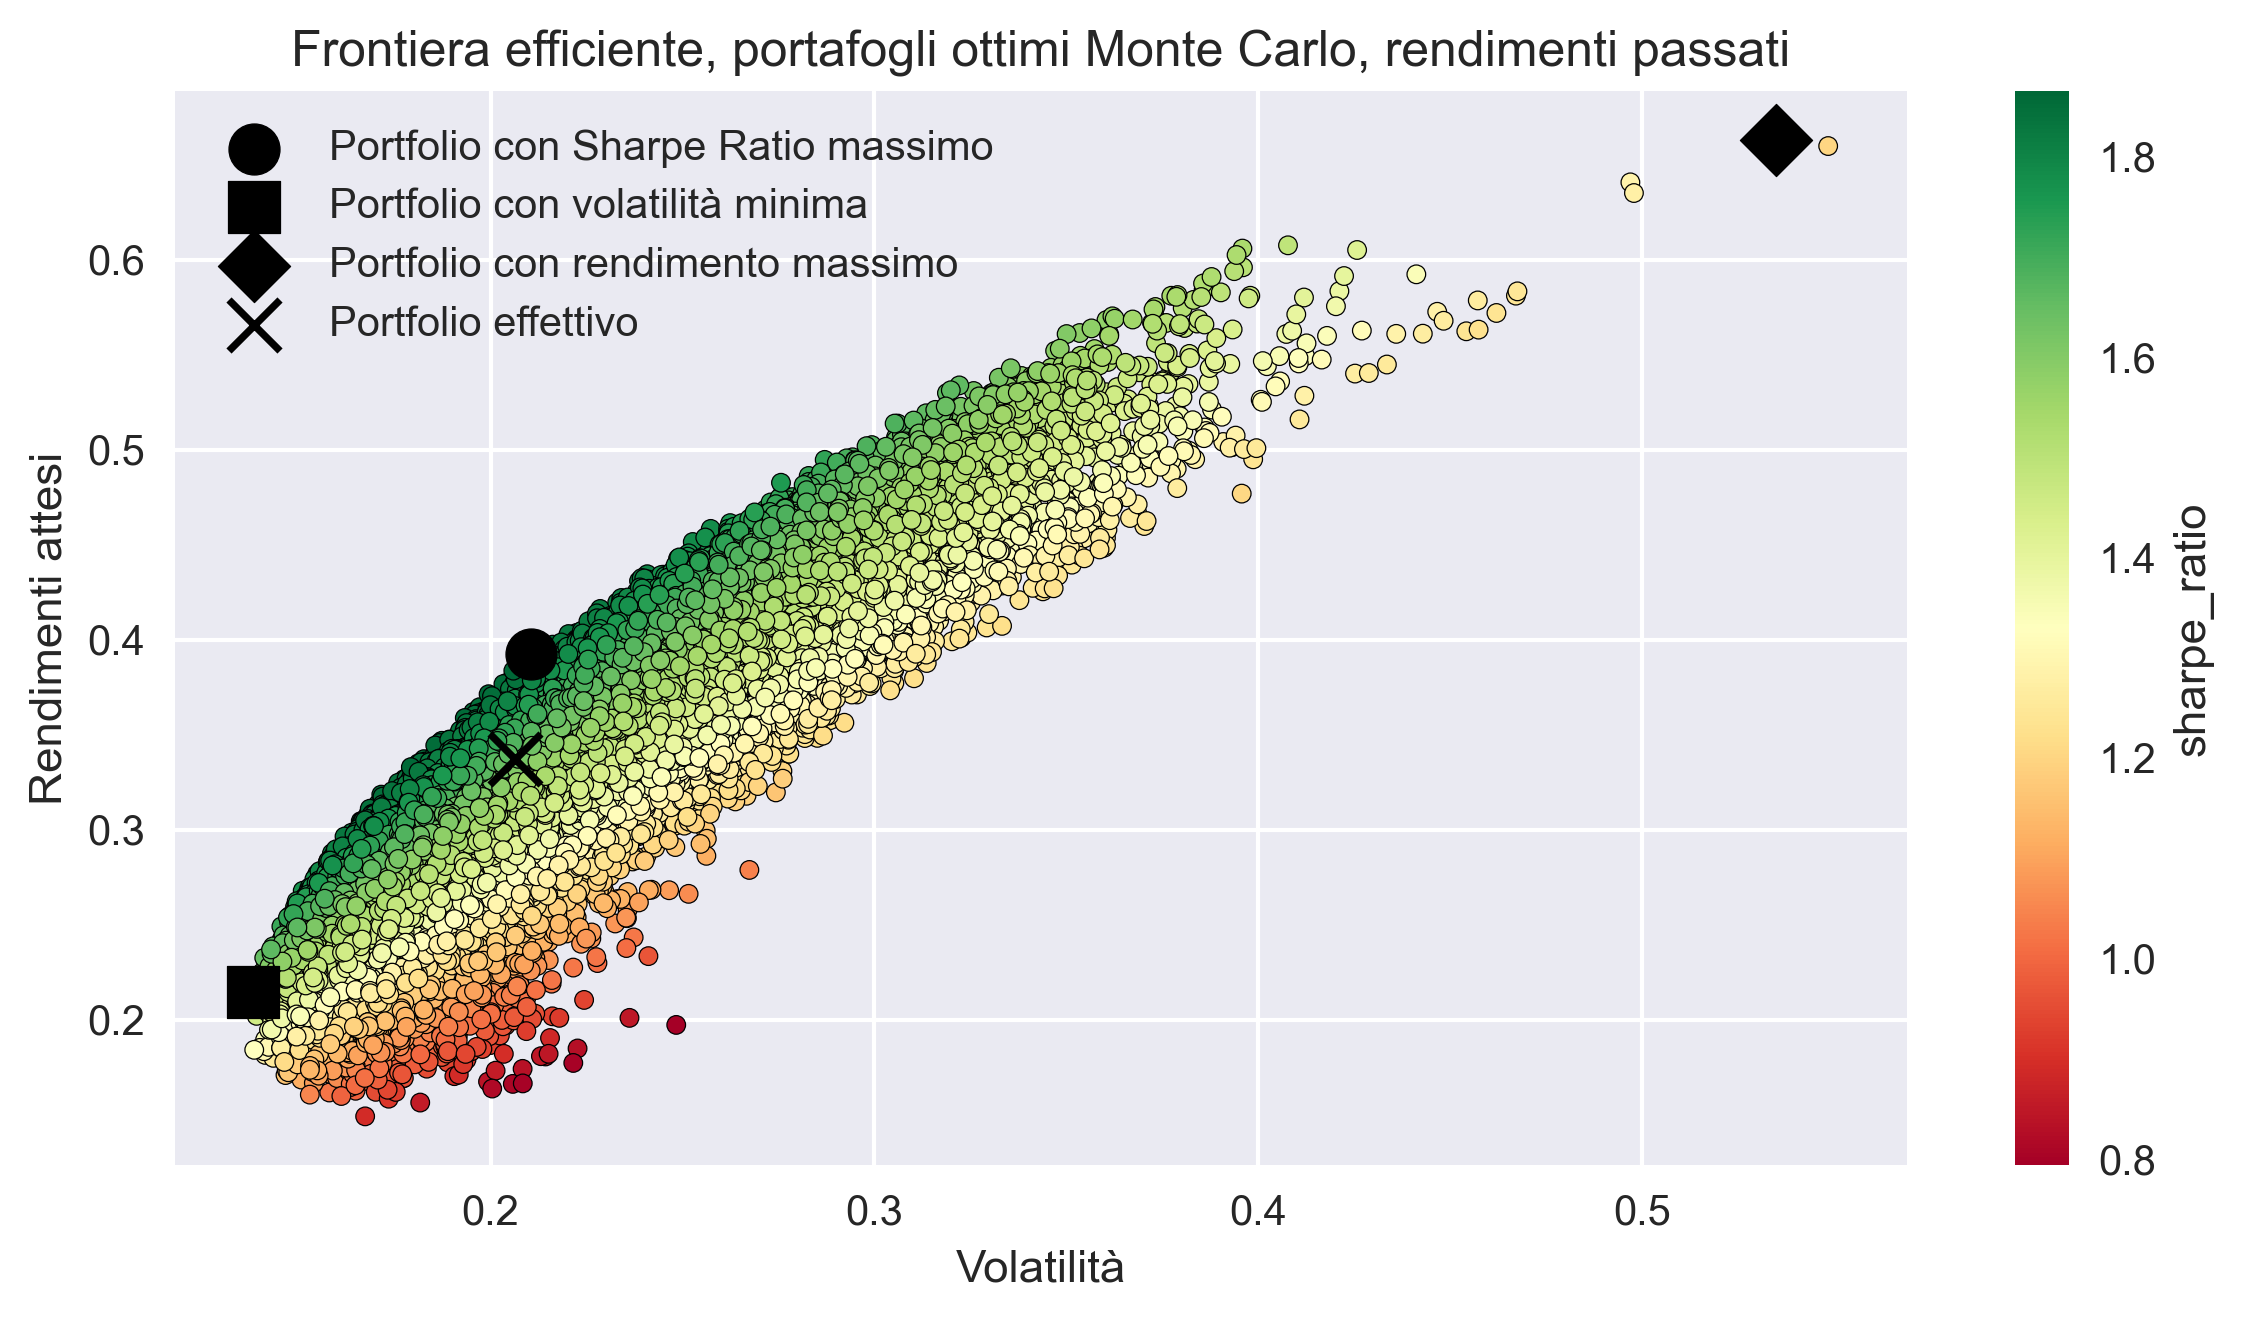

In [80]:
# mostro gli ottimi in un grafico

fig, ax = plt.subplots()
portfolio_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)

ax.scatter(x=max_sr_portfolio.volatility, 
           y=max_sr_portfolio.returns, 
           c='black', marker='o', 
           s=150, label='Portfolio con Sharpe Ratio massimo')

ax.scatter(x=min_vol_portfolio.volatility, 
           y=min_vol_portfolio.returns, 
           c='black', marker='s', 
           s=150, label='Portfolio con volatilità minima')

ax.scatter(x=max_ret_portfolio.volatility, 
           y=max_ret_portfolio.returns, 
           c='black', marker='D', 
           s=150, label='Portfolio con rendimento massimo')

ax.scatter(x=eff_portfolio['volatility'], 
           y=eff_portfolio['returns'], 
           c='black', marker='x', 
           s=150, label='Portfolio effettivo')


ax.set(xlabel='Volatilità', ylabel='Rendimenti attesi', 
       title='Frontiera efficiente, portafogli ottimi Monte Carlo, rendimenti passati')
ax.legend()

plt.tight_layout()

plt.show()

### Metodo di simulazione (Monte Carlo), rendimenti attesi costruiti nel punto 5

In [81]:
# rendimenti
avg_ret = np.array(list(m_expected_ret.values()))

In [82]:
# da qui tutto uguale a prima

np.random.seed(42)
weights = np.random.random(size=(n_portfolio, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

portfolio_rtn = np.dot(weights, avg_ret)

portfolio_vol = []
for i in range(0, len(weights)):
    portfolio_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portfolio_vol = np.array(portfolio_vol)  

portfolio_results_df = pd.DataFrame({'returns': portfolio_rtn,
                                 'volatility': portfolio_vol,
                                 'sharpe_ratio': portfolio_rtn / portfolio_vol})

expected_rtn_min = portfolio_results_df.returns.min() # lo riutilizzerò
expected_rtn_max = portfolio_results_df.returns.max()

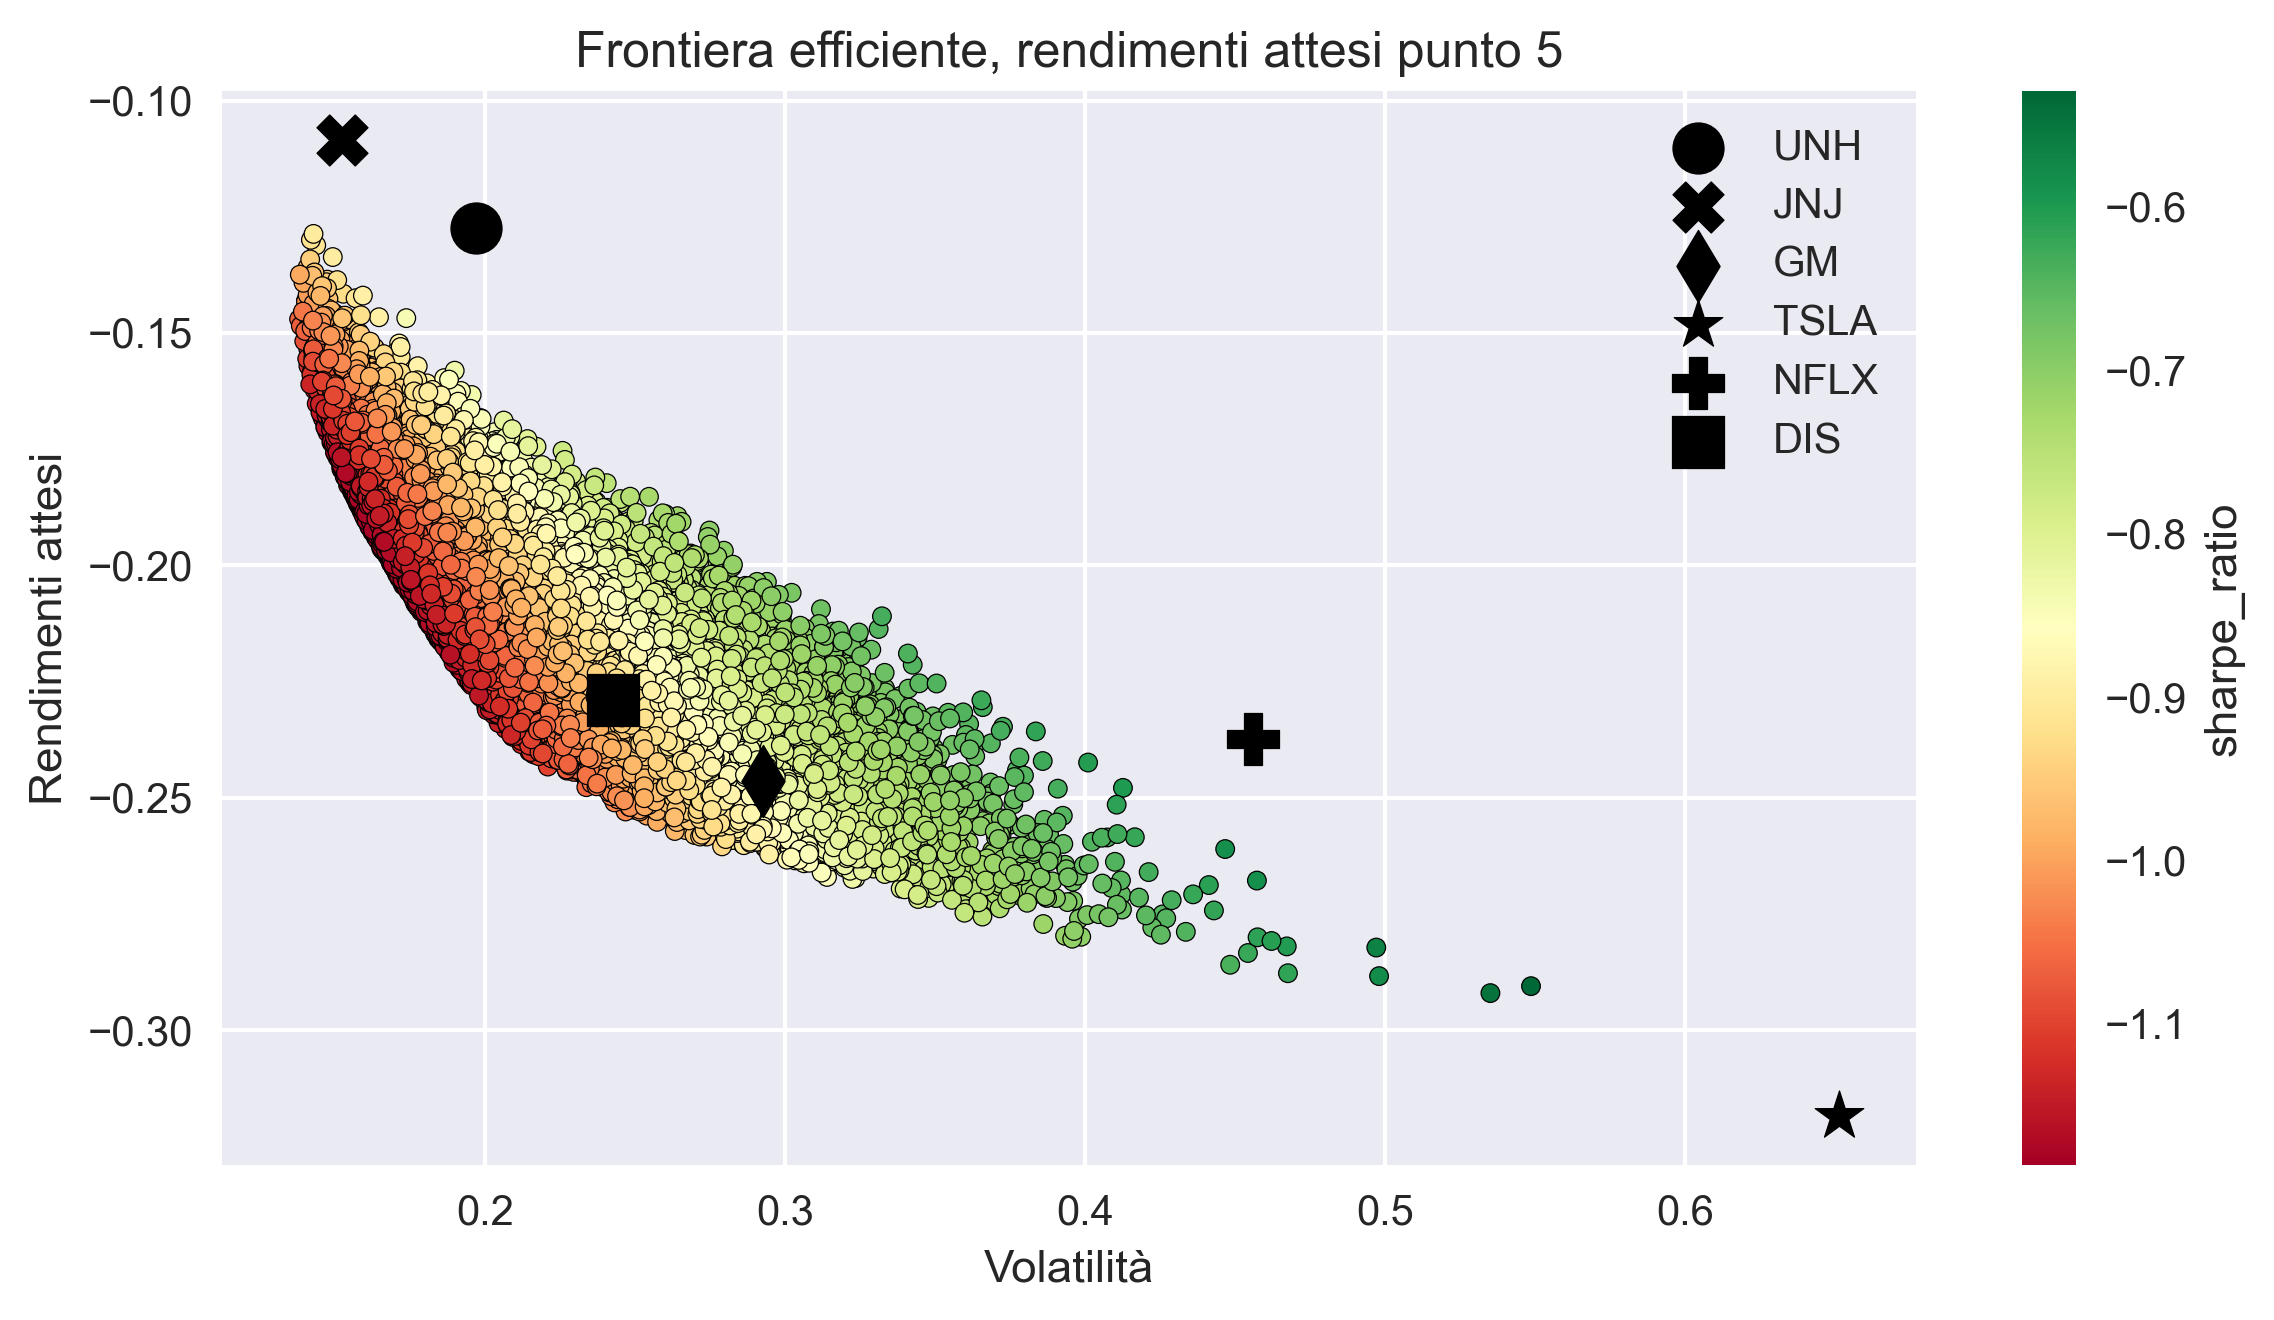

In [83]:
plt.style.use('seaborn')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

MARKS = ['o', 'X', 'd', '*', 'P', 's']

fig, ax = plt.subplots()
portfolio_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatilità', 
       ylabel='Rendimenti attesi', 
       title='Frontiera efficiente, rendimenti attesi punto 5')

for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_ret[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=stocks_names[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

In [84]:
# max sharpe ratio

max_sr = np.argmax(portfolio_results_df.sharpe_ratio)
max_sr_portfolio = portfolio_results_df.loc[max_sr]
max_sr_weights = weights[np.argmax(portfolio_results_df.sharpe_ratio)]

print_portfolio(max_sr_portfolio, "Portfolio con sharpe ratio massimo")
print("=== Pesi portfolio con max sr ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_sr_weights[index])

# beta portfolio

beta_max_sr = np.dot(max_sr_weights, list(betas.values()))
    
print("\n=== Beta portfolio con max sr rispetto al mercato ===")
print("Beta: ", beta_max_sr)

    
print("\n\n---------------------------------------------------------------------------\n\n")

# min volatility

min_vol = np.argmin(portfolio_results_df.volatility)
min_vol_portfolio = portfolio_results_df.loc[min_vol]
min_vol_weights = weights[np.argmin(portfolio_results_df.volatility)]

print_portfolio(min_vol_portfolio, "Portfolio con volatilità minima")
print("=== Pesi portfolio con min volatility ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", min_vol_weights[index])

# beta portfolio

beta_min_vol = np.dot(min_vol_weights, list(betas.values()))

print("\n=== Beta portfolio con min volatility rispetto al mercato ===")
print("Beta: ", beta_min_vol)
    

print("\n\n---------------------------------------------------------------------------\n\n")
    
# max returns

max_ret = np.argmax(portfolio_results_df.returns)
max_ret_portfolio = portfolio_results_df.loc[max_ret]
max_ret_weights = weights[np.argmax(portfolio_results_df.returns)]

print_portfolio(max_ret_portfolio, "Portfolio con rendimento massimo")
print("=== Pesi portfolio con max returns ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_ret_weights[index])
    
# beta portfolio

beta_max_ret = np.dot(max_ret_weights, list(betas.values()))
    
print("\n=== Beta portfolio con max returns rispetto al mercato ===")
print("Beta: ", beta_max_ret)

=== Portfolio con sharpe ratio massimo ===
Rendimento atteso:  -0.29050391819920623
Volatilità:  0.5485356456543079
Sharpe Ratio:  -0.5295989795753118 

=== Pesi portfolio con max sr ===
UNH:  0.0015573575497629072
JNJ:  0.11061749348275861
GM:  0.045939617394172044
TSLA:  0.8274675383306458
NFLX:  0.014354808537916167
DIS:  6.318470474443617e-05

=== Beta portfolio con max sr rispetto al mercato ===
Beta:  1.5968123967871992


---------------------------------------------------------------------------


=== Portfolio con volatilità minima ===
Rendimento atteso:  -0.14701196385791515
Volatilità:  0.1381672906715728
Sharpe Ratio:  -1.0640142333496745 

=== Pesi portfolio con min volatility ===
UNH:  0.24875712553015525
JNJ:  0.4963599421654836
GM:  0.09560040979242178
TSLA:  0.005935251819709933
NFLX:  0.10212642866696281
DIS:  0.05122084202526655

=== Beta portfolio con min volatility rispetto al mercato ===
Beta:  0.8294757425556962


--------------------------------------------------

In [85]:
# portfolio effettivo

weights = np.array([1/6] * n_assets)

eff_portfolio=dict([])

eff_portfolio.update({'returns': np.dot(weights, avg_ret)})
eff_portfolio.update({'volatility': np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))})
eff_portfolio.update({'sharpe_ratio': eff_portfolio['returns'] / eff_portfolio['volatility']})

print_portfolio(eff_portfolio, "Portfolio effettivo")

beta_eff = np.dot(weights, list(betas.values()))
print("Beta: ", beta_eff)

=== Portfolio effettivo ===
Rendimento atteso:  -0.2112132601189537
Volatilità:  0.20633648614572303
Sharpe Ratio:  -1.0236350539079477 

Beta:  1.172798182454298


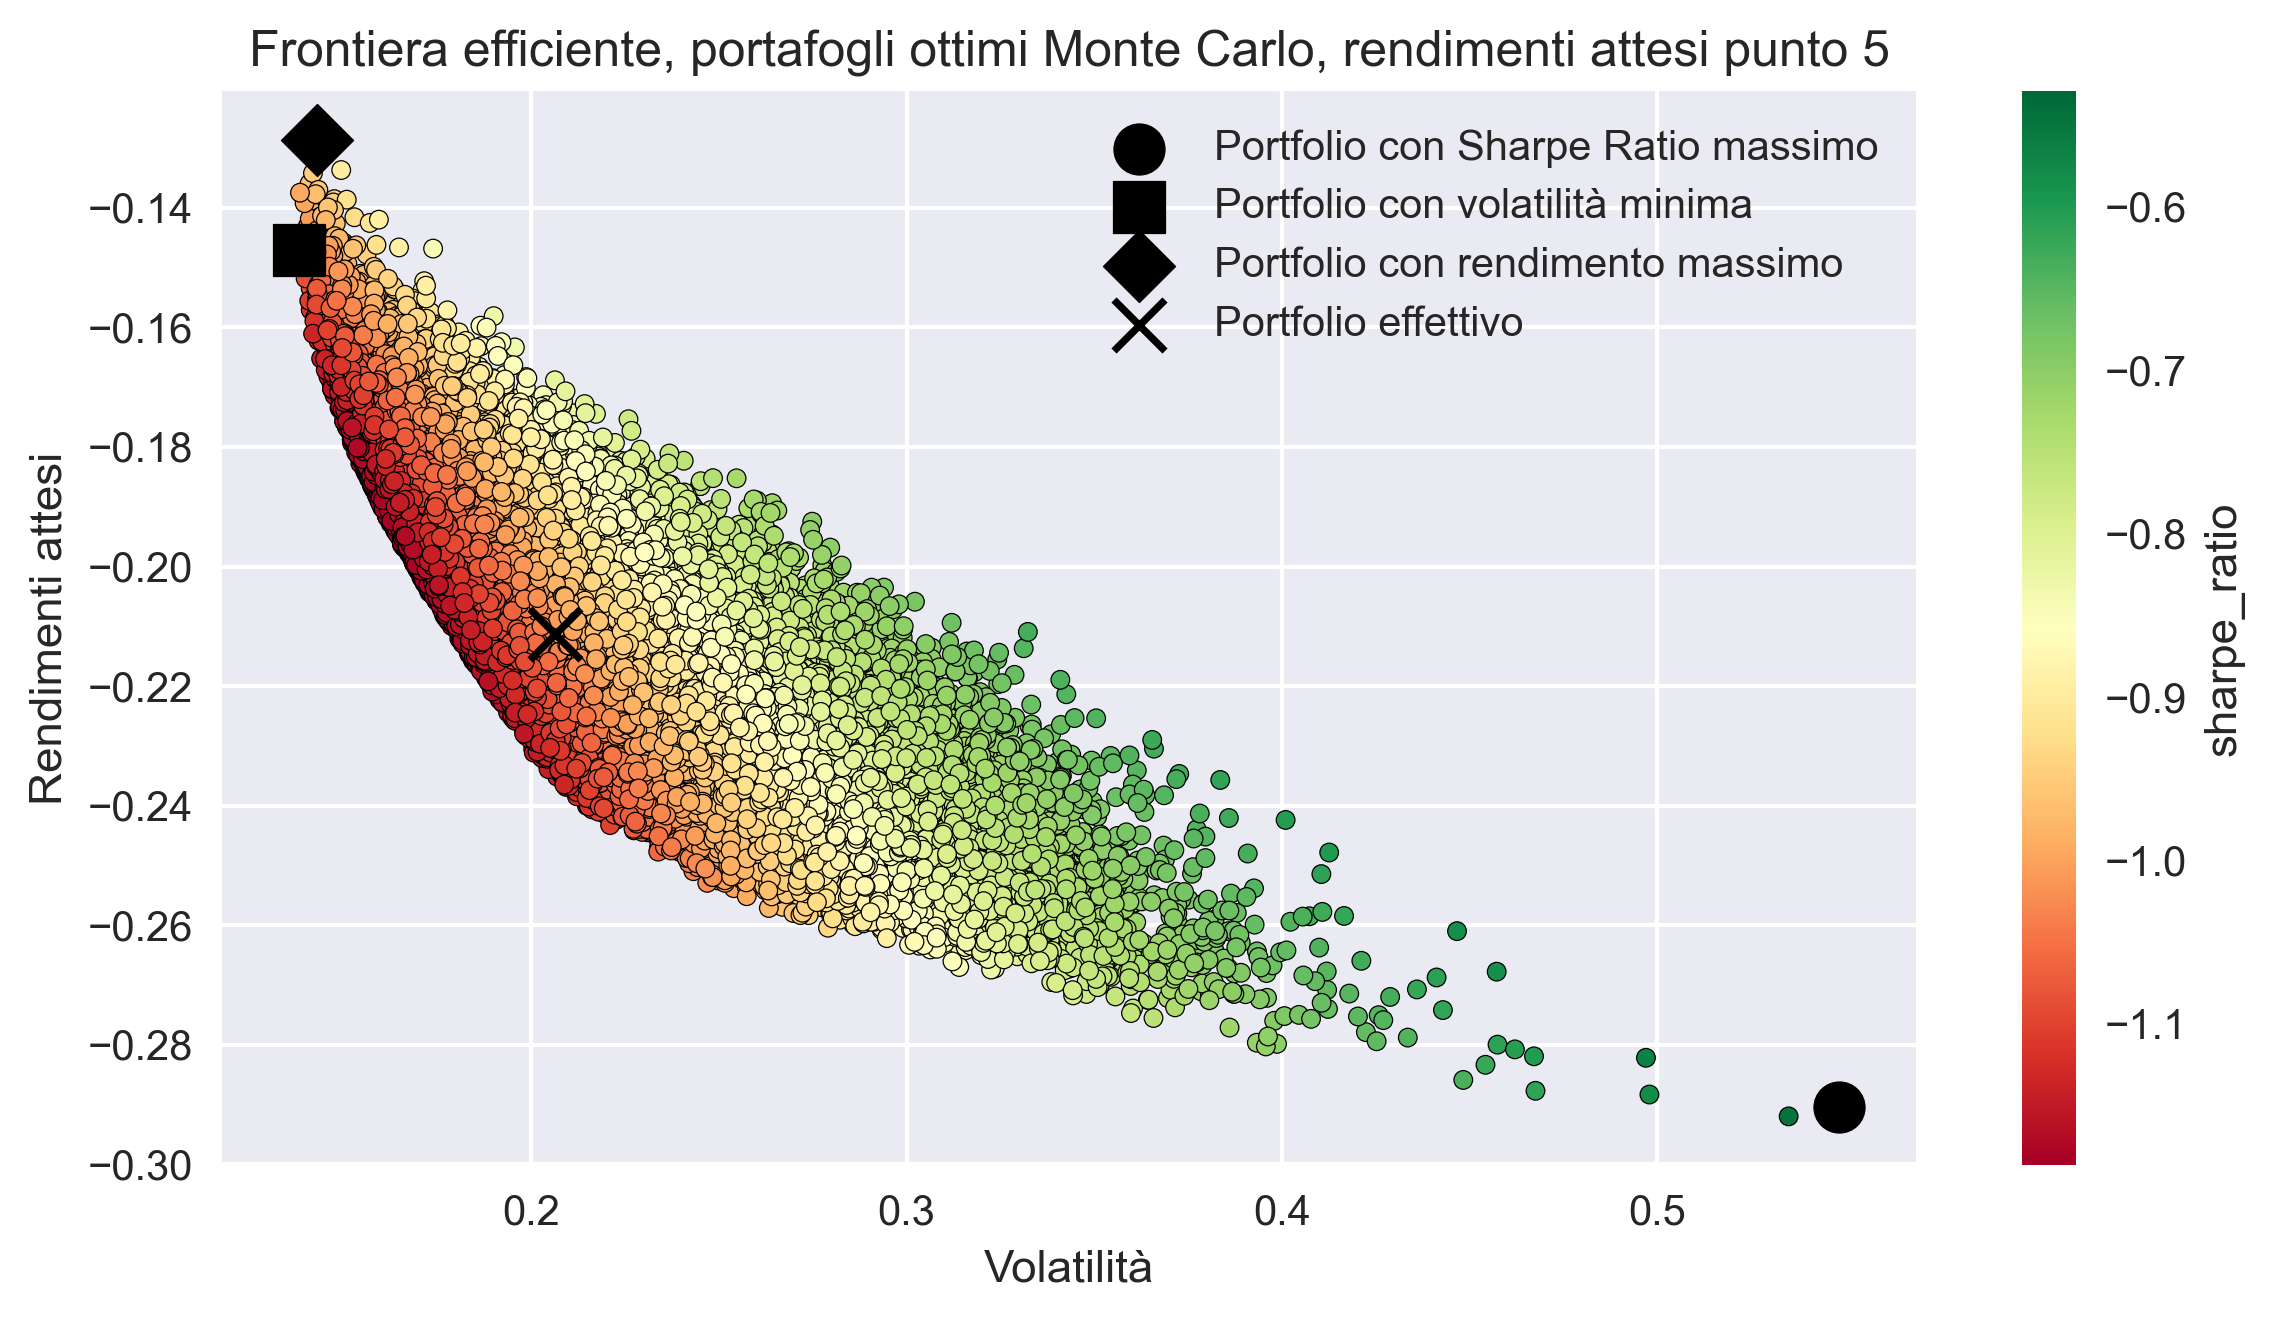

In [86]:
fig, ax = plt.subplots()
portfolio_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)

ax.scatter(x=max_sr_portfolio.volatility, 
           y=max_sr_portfolio.returns, 
           c='black', marker='o', 
           s=150, label='Portfolio con Sharpe Ratio massimo')

ax.scatter(x=min_vol_portfolio.volatility, 
           y=min_vol_portfolio.returns, 
           c='black', marker='s', 
           s=150, label='Portfolio con volatilità minima')

ax.scatter(x=max_ret_portfolio.volatility, 
           y=max_ret_portfolio.returns, 
           c='black', marker='D', 
           s=150, label='Portfolio con rendimento massimo')

ax.scatter(x=eff_portfolio['volatility'], 
           y=eff_portfolio['returns'], 
           c='black', marker='x', 
           s=150, label='Portfolio effettivo')


ax.set(xlabel='Volatilità', ylabel='Rendimenti attesi', 
       title='Frontiera efficiente, portafogli ottimi Monte Carlo, rendimenti attesi punto 5')
ax.legend()

plt.tight_layout()

plt.show()

### Metodo analitico (SciPy), rendimenti passati

In [87]:
# rendimenti
avg_ret = ret_df.mean() * n_period
# cov_mat già definita
rtns_range = np.linspace(past_rtn_min, # riutilizzo le variabili definite prima
                         past_rtn_max,
                         200)

In [88]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

def get_efficient_frontier():
    
    efficient_portfolios = []
    
    n_assets = len(avg_ret)
    args = (avg_ret, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_ret) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [89]:
efficient_portfolios = get_efficient_frontier()

vols_range = [x['fun'] for x in efficient_portfolios]

In [90]:
# preparazione dataframe

all_portfolio_df = pd.DataFrame()

all_portfolio_df.index = [i for i in range(0,len(vols_range))]

all_portfolio_df['returns'] = np.nan
all_portfolio_df['volatility'] = np.nan
all_portfolio_df['sharpe_ratio'] = np.nan

for vol in range(0,len(vols_range)):
    all_portfolio_df.iloc[vol, 0] = rtns_range[vol] # returns
    all_portfolio_df.iloc[vol, 1] = efficient_portfolios[vol]['fun'] # volatility
    all_portfolio_df.iloc[vol, 2] = rtns_range[vol] / efficient_portfolios[vol]['fun'] # sharpe_ratio
    

all_portfolio_df.tail()

returns  volatility  sharpe_ratio
195  0.652573    0.436026      1.496636
196  0.655154    0.439055      1.492191
197  0.657735    0.442223      1.487340
198  0.660317    0.445526      1.482106
199  0.662898    0.448962      1.476512

In [91]:
# max sharpe ratio

max_sr = np.argmax(all_portfolio_df.sharpe_ratio)
max_sr_portfolio = all_portfolio_df.loc[max_sr]
max_sr_weights = efficient_portfolios[max_sr]['x']

print_portfolio(max_sr_portfolio, "(SciPy) Portfolio con sharpe ratio massimo")
print("=== (SciPy) Pesi portfolio con max sr ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_sr_weights[index])

# beta portfolio

beta_max_sr = np.dot(max_sr_weights, list(betas.values()))
    
print("\n=== (SciPy) Beta portfolio con max sr rispetto al mercato ===")
print("Beta: ", beta_max_sr)

    
print("\n\n---------------------------------------------------------------------------\n\n")

# min volatility

min_vol = np.argmin(all_portfolio_df.volatility)
min_vol_portfolio = all_portfolio_df.loc[min_vol]
min_vol_weights = efficient_portfolios[min_vol]['x']

print_portfolio(min_vol_portfolio, "(SciPy) Portfolio con volatilità minima")
print("=== (SciPy) Pesi portfolio con min volatility ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", min_vol_weights[index])

# beta portfolio

beta_min_vol = np.dot(min_vol_weights, list(betas.values()))

print("\n=== (SciPy) Beta portfolio con min volatility rispetto al mercato ===")
print("Beta: ", beta_min_vol)
    

print("\n\n---------------------------------------------------------------------------\n\n")
    
# max returns

max_ret = np.argmax(all_portfolio_df.returns)
max_ret_portfolio = all_portfolio_df.loc[max_ret]
max_ret_weights = efficient_portfolios[max_ret]['x']

print_portfolio(max_ret_portfolio, "(SciPy) Portfolio con rendimento massimo")
print("=== Pesi portfolio con max returns ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_ret_weights[index])
    
# beta portfolio

beta_max_ret = np.dot(max_ret_weights, list(betas.values()))
    
print("\n=== (SciPy) Beta portfolio con max returns rispetto al mercato ===")
print("Beta: ", beta_max_ret)

=== (SciPy) Portfolio con sharpe ratio massimo ===
Rendimento atteso:  0.3608670245141204
Volatilità:  0.19196908646725094
Sharpe Ratio:  1.879818418449799 

=== (SciPy) Pesi portfolio con max sr ===
UNH:  0.5445488176790393
JNJ:  0.13696613896400953
GM:  1.7228650147152469e-18
TSLA:  0.10557449266010176
NFLX:  0.21291055069684947
DIS:  7.521652571618187e-19

=== (SciPy) Beta portfolio con max sr rispetto al mercato ===
Beta:  0.9442263402745469


---------------------------------------------------------------------------


=== (SciPy) Portfolio con volatilità minima ===
Rendimento atteso:  0.19049033882105015
Volatilità:  0.13547719228709715
Sharpe Ratio:  1.406069432095785 

=== (SciPy) Pesi portfolio con min volatility ===
UNH:  0.21947367220409236
JNJ:  0.6130334916658677
GM:  0.09400739107005383
TSLA:  6.613633252161577e-18
NFLX:  0.06598391565782029
DIS:  0.007501529402165844

=== (SciPy) Beta portfolio con min volatility rispetto al mercato ===
Beta:  0.7656126807059442


------

### Metodo analitico (SciPy), rendimenti attesi costruiti nel punto 5

In [92]:
# rendimenti
avg_ret = np.array(list(m_expected_ret.values()))
# cov_mat già definita
rtns_range = np.linspace(expected_rtn_min, # diverse dalle variabili per rendimenti passati
                         expected_rtn_max,
                         200)

In [93]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

def get_efficient_frontier():
    
    efficient_portfolios = []
    
    n_assets = len(avg_ret)
    args = (avg_ret, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_ret) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [94]:
efficient_portfolios = get_efficient_frontier()

vols_range = [x['fun'] for x in efficient_portfolios]

In [95]:
# preparazione dataframe

all_portfolio_df = pd.DataFrame()

all_portfolio_df.index = [i for i in range(0,len(vols_range))]

all_portfolio_df['returns'] = np.nan
all_portfolio_df['volatility'] = np.nan
all_portfolio_df['sharpe_ratio'] = np.nan

for vol in range(0,len(vols_range)):
    all_portfolio_df.iloc[vol, 0] = rtns_range[vol] # returns
    all_portfolio_df.iloc[vol, 1] = efficient_portfolios[vol]['fun'] # volatility
    all_portfolio_df.iloc[vol, 2] = rtns_range[vol] / efficient_portfolios[vol]['fun'] # sharpe_ratio
    

all_portfolio_df.tail()

returns  volatility  sharpe_ratio
195 -0.131970    0.135579     -0.973384
196 -0.131150    0.135647     -0.966846
197 -0.130329    0.135733     -0.960191
198 -0.129509    0.135837     -0.953414
199 -0.128688    0.135959     -0.946520

In [96]:
# max sharpe ratio

max_sr = np.argmax(all_portfolio_df.sharpe_ratio)
max_sr_portfolio = all_portfolio_df.loc[max_sr]
max_sr_weights = efficient_portfolios[max_sr]['x']

print_portfolio(max_sr_portfolio, "(SciPy) Portfolio con sharpe ratio massimo")
print("=== (SciPy) Pesi portfolio con max sr ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_sr_weights[index])

# beta portfolio

beta_max_sr = np.dot(max_sr_weights, list(betas.values()))
    
print("\n=== (SciPy) Beta portfolio con max sr rispetto al mercato ===")
print("Beta: ", beta_max_sr)

    
print("\n\n---------------------------------------------------------------------------\n\n")

# min volatility

min_vol = np.argmin(all_portfolio_df.volatility)
min_vol_portfolio = all_portfolio_df.loc[min_vol]
min_vol_weights = efficient_portfolios[min_vol]['x']

print_portfolio(min_vol_portfolio, "(SciPy) Portfolio con volatilità minima")
print("=== (SciPy) Pesi portfolio con min volatility ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", min_vol_weights[index])

# beta portfolio

beta_min_vol = np.dot(min_vol_weights, list(betas.values()))

print("\n=== (SciPy) Beta portfolio con min volatility rispetto al mercato ===")
print("Beta: ", beta_min_vol)
    

print("\n\n---------------------------------------------------------------------------\n\n")
    
# max returns

max_ret = np.argmax(all_portfolio_df.returns)
max_ret_portfolio = all_portfolio_df.loc[max_ret]
max_ret_weights = efficient_portfolios[max_ret]['x']

print_portfolio(max_ret_portfolio, "(SciPy) Portfolio con rendimento massimo")
print("=== Pesi portfolio con max returns ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_ret_weights[index])
    
# beta portfolio

beta_max_ret = np.dot(max_ret_weights, list(betas.values()))
    
print("\n=== (SciPy) Beta portfolio con max returns rispetto al mercato ===")
print("Beta: ", beta_max_ret)

=== (SciPy) Portfolio con sharpe ratio massimo ===
Rendimento atteso:  -0.2919989089429287
Volatilità:  0.45563633490053906
Sharpe Ratio:  -0.640859577203537 

=== (SciPy) Pesi portfolio con max sr ===
UNH:  0.0
JNJ:  2.7474027049996284e-16
GM:  0.36732760307417367
TSLA:  0.6326723969258268
NFLX:  0.0
DIS:  0.0

=== (SciPy) Beta portfolio con max sr rispetto al mercato ===
Beta:  1.6048069996526557


---------------------------------------------------------------------------


=== (SciPy) Portfolio con volatilità minima ===
Rendimento atteso:  -0.13525311162677653
Volatilità:  0.1354765893709508
Sharpe Ratio:  -0.9983504327558589 

=== (SciPy) Pesi portfolio con min volatility ===
UNH:  0.21897837654685914
JNJ:  0.6120061294678255
GM:  0.09416836671107506
TSLA:  0.0
NFLX:  0.06678853803211184
DIS:  0.00805858924212836

=== (SciPy) Beta portfolio con min volatility rispetto al mercato ===
Beta:  0.7665941798652367


-----------------------------------------------------------------------